## EDA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, Normalizer, FunctionTransformer
from sklearn import metrics
from sklearn.pipeline import Pipeline, FeatureUnion

from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Dropout, Activation, Flatten, MaxPool2D
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In [3]:
!ls ../assets

mapdata_copyright_openstreetmap_contributors.rds
mapdata_copyright_openstreetmap_contributors.txt
noaa_weather_qclcd_documentation.pdf
sampleSubmission.csv
spray.csv
test.csv
train.csv
weather.csv


In [4]:
df_train = pd.read_csv('../assets/train.csv')

In [5]:
df_train['Trap'].value_counts().head()

T900    750
T115    542
T138    314
T002    185
T135    183
Name: Trap, dtype: int64

In [6]:
df_test = pd.read_csv('../assets/test.csv')

In [7]:
df_spray = pd.read_csv('../assets/spray.csv')

In [8]:
df_weather = pd.read_csv('../assets/weather.csv')

In [9]:
df_train.shape, df_test.shape, df_spray.shape, df_weather.shape

((10506, 12), (116293, 11), (14835, 4), (2944, 22))

In [10]:
# drop irrelevant columns
train = df_train.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], axis=1)

In [11]:
# baseline accuracy; it means that 95% accuracy just by answering '0' 
train['WnvPresent'].value_counts()[0]/train['WnvPresent'].value_counts().sum()

0.94755377879307068

In [12]:
train['Date'] = pd.to_datetime(train['Date'])

In [13]:
test = df_test.drop(['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], axis=1)

In [14]:
test['Date'] = pd.to_datetime(test['Date'])

In [15]:
test.head()

Id       Date                 Species  Trap  Latitude  Longitude
0   1 2008-06-11  CULEX PIPIENS/RESTUANS  T002  41.95469 -87.800991
1   2 2008-06-11          CULEX RESTUANS  T002  41.95469 -87.800991
2   3 2008-06-11           CULEX PIPIENS  T002  41.95469 -87.800991
3   4 2008-06-11        CULEX SALINARIUS  T002  41.95469 -87.800991
4   5 2008-06-11         CULEX TERRITANS  T002  41.95469 -87.800991

In [16]:
spray = df_spray.copy()

In [17]:
spray['Date'] = pd.to_datetime(spray['Date'])

In [18]:
df_weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [19]:
weather  = df_weather.drop(['Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1', 'SnowFall'], axis=1)

In [20]:
weather.loc[2743, 'SeaLevel']

'M'

In [21]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 16 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(10)
memory usage: 368.1+ KB


In [22]:
weather.head(10)

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   
5        2  2007-05-03    67    48   58      M        40      50    7    0   
6        1  2007-05-04    66    49   58      4        41      50    7    0   
7        2  2007-05-04    78    51    M      M        42      50    M    M   
8        1  2007-05-05    66    53   60      5        38      49    5    0   
9        2  2007-05-05    66    54   60      M        39      50    5    0   

  PrecipTotal StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
0        0.00       29.10    29.82          1.7         27      9.2  
1        0.00       29.18    29.82          2.7         25      9.6  
2        0.00       29.38    30.09         13.0          4     13.4  
3        0.00       29.44    30.08         13.3          2     13.4  
4        0.00       29.39    30.12         11.7          7     11.9  
5        0.00       29.46    30.12         12.9          6     13.2  
6           T       29.31    30.05         10.4          8     10.8  
7        0.00       29.36    30.04         10.1          7     10.4  
8           T       29.40    30.10         11.7          7     12.0  
9           T       29.46    30.09         11.2          7     11.5

In [23]:
weather.shape

(2944, 16)

In [24]:
weather['Date'] = pd.to_datetime(weather['Date'])

In [25]:
def count_Ms_Ts(df):
    print('{0:13s} {1:>5s} {2:>5s} {3:>8s} {4:>8s}'.format('column', 'Ms', 'Ts', 'Others', 'Total'))
    for col in df.columns:
        cnt_M = 0
        cnt_T = 0
        cnt_O = 0
        for i, row in df.iterrows():
            if row[col] == 'M':
                cnt_M += 1
###                print('(M) index=',i)
            elif row[col] == '  T':
                cnt_T += 1
###                print('(T) index=',i)
            else:
                if col != 'Date':
                    cnt_O += 1
                    try:
                        float(row[col])
                    except ValueError:
                        print('ERROR:', i, row['Station'], row[col])
        print('{0:13s} {1:5.0f} {2:5.0f} {3:8.0f} {4:8.0f}'.format(col, cnt_M, cnt_T, cnt_O, cnt_M+cnt_T+cnt_O))

In [26]:
count_Ms_Ts(weather)

column           Ms    Ts   Others    Total
Station           0     0     2944     2944
Date              0     0        0        0
Tmax              0     0     2944     2944
Tmin              0     0     2944     2944
Tavg             11     0     2933     2944
Depart         1472     0     1472     2944
DewPoint          0     0     2944     2944
WetBulb           4     0     2940     2944
Heat             11     0     2933     2944
Cool             11     0     2933     2944
PrecipTotal       2   318     2624     2944
StnPressure       4     0     2940     2944
SeaLevel          9     0     2935     2944
ResultSpeed       0     0     2944     2944
ResultDir         0     0     2944     2944
AvgSpeed          3     0     2941     2944


In [27]:
# The 11 M's are Tavg, Heat, and Cool are all in the same rows.  It is better to drop all of them than replacing them
# by speculative values.
Tavg_Ms = weather[ weather['Tavg']=='M' ].index.tolist()
weather.drop(index=Tavg_Ms, axis=0, inplace=True)

In [28]:
Tavg_Ms

[7, 505, 675, 1637, 2067, 2211, 2501, 2511, 2525, 2579, 2811]

In [29]:
# The 2 M's in PrecipTotal are from Station 2 and can be replaced by the values in Station 1 of the same days.
weather[ weather['PrecipTotal']=='M' ]

Station       Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
117        2 2007-06-28    73    61   67      M        56      61    0    2   
119        2 2007-06-29    71    56   64      M        56      60    1    0   

    PrecipTotal StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
117           M       29.43    30.07         12.2          2     13.3  
119           M       29.47    30.11          7.4          2      8.2

In [30]:
weather.loc[117, 'PrecipTotal'] = weather.loc[116, 'PrecipTotal']
weather.loc[119, 'PrecipTotal'] = weather.loc[118, 'PrecipTotal']

In [31]:
# 4 M's in WetBulb of one station should be manually replaced by the values of the other station of the same day.
weather[ weather['WetBulb']=='M' ]

Station       Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
848         1 2009-06-26    86    69   78      7        60       M    0   13   
2410        1 2013-08-10    81    64   73      0        57       M    0    8   
2412        1 2013-08-11    81    60   71     -2        61       M    0    6   
2415        2 2013-08-12    85    69   77      M        63       M    0   12   

     PrecipTotal StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
848         0.00           M    29.85          6.4          4      8.2  
2410        0.00           M    30.08          5.3          5      6.5  
2412        0.01       29.35    30.07          2.0         27      3.0  
2415        0.66       29.27    29.92          4.5         26      7.7

In [32]:
weather.loc[848, 'WetBulb'] = weather.loc[849, 'WetBulb']
weather.loc[2410, 'WetBulb'] = weather.loc[2411, 'WetBulb']
weather.loc[2412, 'WetBulb'] = weather.loc[2413, 'WetBulb']
weather.loc[2415, 'WetBulb'] = weather.loc[2414, 'WetBulb']

In [33]:
# The first 2 M's in StnPressure in one station should also be manually replaced by the values of the other station
# of the same day.  The other 2 M's are in the same day, so we can simply drop those rows.
weather[ weather['StnPressure']=='M' ]

Station       Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
87          2 2007-06-13    86    68   77      M        53      62    0   12   
848         1 2009-06-26    86    69   78      7        60      67    0   13   
2410        1 2013-08-10    81    64   73      0        57      63    0    8   
2411        2 2013-08-10    81    68   75      M        55      63    0   10   

     PrecipTotal StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
87          0.00           M        M          7.0          5        M  
848         0.00           M    29.85          6.4          4      8.2  
2410        0.00           M    30.08          5.3          5      6.5  
2411        0.00           M    30.07          6.0          6      7.4

In [34]:
weather.loc[87, 'StnPressure'] = weather.loc[86, 'StnPressure']
weather.loc[848, 'StnPressure'] = weather.loc[849, 'StnPressure']
weather.drop(index=[2410, 2411], inplace=True)

In [35]:
# Replace 318 T's in PrecipTotal by 0.00.
weather['PrecipTotal'] = weather['PrecipTotal'].str.strip().replace('T','0')

In [36]:
# It is better to drop the 9 M's in SeaLevel than replacing them by speculative values.
SeaLevel_Ms = weather[ weather['SeaLevel']=='M' ].index.tolist()
weather.drop(index=SeaLevel_Ms, axis=0, inplace=True)

In [37]:
# It is better to drop the 3 M's in AvgSpeed than replacing them by speculative values.
AvgSpeed_Ms = weather[ (weather['AvgSpeed']=='M') | (weather['AvgSpeed'].isna()) ].index.tolist()
weather.drop(index=AvgSpeed_Ms, axis=0, inplace=True)

In [38]:
# 1472 M's in Depart appears only in Station 2, so simply drop them.
Depart_Ms = weather[ (weather['Depart']=='M') ].index.tolist()
weather.drop(index=Depart_Ms, axis=0, inplace=True)

In [39]:
count_Ms_Ts(weather)

column           Ms    Ts   Others    Total
Station           0     0     1466     1466
Date              0     0        0        0
Tmax              0     0     1466     1466
Tmin              0     0     1466     1466
Tavg              0     0     1466     1466
Depart            0     0     1466     1466
DewPoint          0     0     1466     1466
WetBulb           0     0     1466     1466
Heat              0     0     1466     1466
Cool              0     0     1466     1466
PrecipTotal       0     0     1466     1466
StnPressure       0     0     1466     1466
SeaLevel          0     0     1466     1466
ResultSpeed       0     0     1466     1466
ResultDir         0     0     1466     1466
AvgSpeed          0     0     1466     1466


In [40]:
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [41]:
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                   object
Depart                 object
DewPoint                int64
WetBulb                object
Heat                   object
Cool                   object
PrecipTotal            object
StnPressure            object
SeaLevel               object
ResultSpeed           float64
ResultDir               int64
AvgSpeed               object
dtype: object

In [42]:
# List of Column Headers
weather_columns = weather.columns.tolist()
print(weather_columns)
print(len(weather_columns))

['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed']
16


In [43]:
#weather_avg = weather.groupby('Date')[weather_columns[3:]].mean().reset_index(level=0)

In [44]:
#weather_avg.tail()

In [45]:
flts = ['PrecipTotal', 'ResultSpeed', 'AvgSpeed','StnPressure', 'SeaLevel']
ints = ['Tavg', 'WetBulb','Heat','Cool','ResultDir','Depart']

In [46]:
# Convert objects to integers
weather[ints] = weather[ints].astype('int')
# Convert objects to floats
weather[flts] = weather[flts].astype('float')

In [47]:
# Farenheit to Celcius for RH calculation
weather[['Tavg(C)','DewPoint(C)','WetBulb(C)']]=weather[['Tavg','DewPoint','WetBulb']].apply(lambda x: (x-32)*(5/9)).round(1)

In [48]:
#Calculation Relative Humidity
weather['RH'] = ((np.exp(17.67*weather['DewPoint(C)']/(243.5+weather['DewPoint(C)'])))*100 /
                 (np.exp((17.67*weather['Tavg(C)']/(243.5+weather['Tavg(C)']))))).round(1)
#weather['RH2'] = ((6.112*np.exp(17.502*weather['WetBulb(C)']/(240.97+weather['WetBulb(C)']))
#                   -0.6687451584*(1.0+0.00115*weather['WetBulb(C)'])*(weather['DewPoint(C)']-weather['WetBulb(C)']))*100 / 
#                 (6.112*np.exp(17.502*weather['DewPoint(C)']/(240.97+weather['DewPoint(C)'])))).round(1)

In [49]:
weather.head()

Station       Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  \
0        1 2007-05-01    83    50    67      14        51       56     0   
2        1 2007-05-02    59    42    51      -3        42       47    14   
4        1 2007-05-03    66    46    56       2        40       48     9   
6        1 2007-05-04    66    49    58       4        41       50     7   
8        1 2007-05-05    66    53    60       5        38       49     5   

   Cool  PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  \
0     2          0.0        29.10     29.82          1.7         27       9.2   
2     0          0.0        29.38     30.09         13.0          4      13.4   
4     0          0.0        29.39     30.12         11.7          7      11.9   
6     0          0.0        29.31     30.05         10.4          8      10.8   
8     0          0.0        29.40     30.10         11.7          7      12.0   

   Tavg(C)  DewPoint(C)  WetBulb(C)    RH  
0     19.4         10.6        13.3  56.7  
2     10.6          5.6         8.3  71.2  
4     13.3          4.4         8.9  54.8  
6     14.4          5.0        10.0  53.2  
8     15.6          3.3         9.4  43.7

In [50]:
weather.shape

(1466, 20)

In [51]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Tavg(C)', 'DewPoint(C)',
       'WetBulb(C)', 'RH'],
      dtype='object')

In [52]:
weather.drop(labels=['Tavg(C)', 'DewPoint(C)', 'WetBulb(C)'], axis=1, inplace=True)

In [53]:
weather.shape

(1466, 17)

In [54]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'RH'],
      dtype='object')

In [55]:
weather.columns.tolist()[2:18]

['Tmax',
 'Tmin',
 'Tavg',
 'Depart',
 'DewPoint',
 'WetBulb',
 'Heat',
 'Cool',
 'PrecipTotal',
 'StnPressure',
 'SeaLevel',
 'ResultSpeed',
 'ResultDir',
 'AvgSpeed',
 'RH']

In [56]:
columns_groupby = weather.columns.tolist()[2:18]
print(columns_groupby)

['Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed', 'RH']


In [57]:
weather.shape

(1466, 17)

In [58]:
weather = weather.groupby('Date')[columns_groupby].mean().reset_index(level=0)

In [59]:
# Shape of weather _new is larger than the shape of station 
weather.shape

(1466, 16)

In [60]:
weather.isnull().sum()

Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
RH             0
dtype: int64

In [61]:
weather.head()

Date  Tmax  Tmin  Tavg  Depart  DewPoint  WetBulb  Heat  Cool  \
0 2007-05-01    83    50    67      14        51       56     0     2   
1 2007-05-02    59    42    51      -3        42       47    14     0   
2 2007-05-03    66    46    56       2        40       48     9     0   
3 2007-05-04    66    49    58       4        41       50     7     0   
4 2007-05-05    66    53    60       5        38       49     5     0   

   PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed    RH  
0          0.0        29.10     29.82          1.7         27       9.2  56.7  
1          0.0        29.38     30.09         13.0          4      13.4  71.2  
2          0.0        29.39     30.12         11.7          7      11.9  54.8  
3          0.0        29.31     30.05         10.4          8      10.8  53.2  
4          0.0        29.40     30.10         11.7          7      12.0  43.7

In [62]:
!pwd

/Users/Lee/GA/projects/project-4/west_nile/working


In [63]:
# create a csv file
weather.to_csv(path_or_buf='./weather.csv')

In [64]:
train.head()

Date                 Species  Trap   Latitude  Longitude  \
0 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
1 2007-05-29          CULEX RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29          CULEX RESTUANS  T007  41.994991 -87.769279   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
4 2007-05-29          CULEX RESTUANS  T015  41.974089 -87.824812   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

## Feature engineering

In [65]:
train_weather = train.merge(weather, how='left', on='Date')

In [66]:
train_weather.to_csv(path_or_buf='./train-weather.csv')

In [67]:
train_weather.head()

Date                 Species  Trap   Latitude  Longitude  \
0 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
1 2007-05-29          CULEX RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29          CULEX RESTUANS  T007  41.994991 -87.769279   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
4 2007-05-29          CULEX RESTUANS  T015  41.974089 -87.824812   

   NumMosquitos  WnvPresent  Tmax  Tmin  Tavg  ...   WetBulb  Heat  Cool  \
0             1           0    88    60    74  ...        65     0     9   
1             1           0    88    60    74  ...        65     0     9   
2             1           0    88    60    74  ...        65     0     9   
3             1           0    88    60    74  ...        65     0     9   
4             4           0    88    60    74  ...        65     0     9   

   PrecipTotal  StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed    RH  
0          0.0        29.39     30.11          5.8         18       6.5  57.3  
1          0.0        29.39     30.11          5.8         18       6.5  57.3  
2          0.0        29.39     30.11          5.8         18       6.5  57.3  
3          0.0        29.39     30.11          5.8         18       6.5  57.3  
4          0.0        29.39     30.11          5.8         18       6.5  57.3  

[5 rows x 22 columns]

In [68]:
train_weather.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'RH'],
      dtype='object')

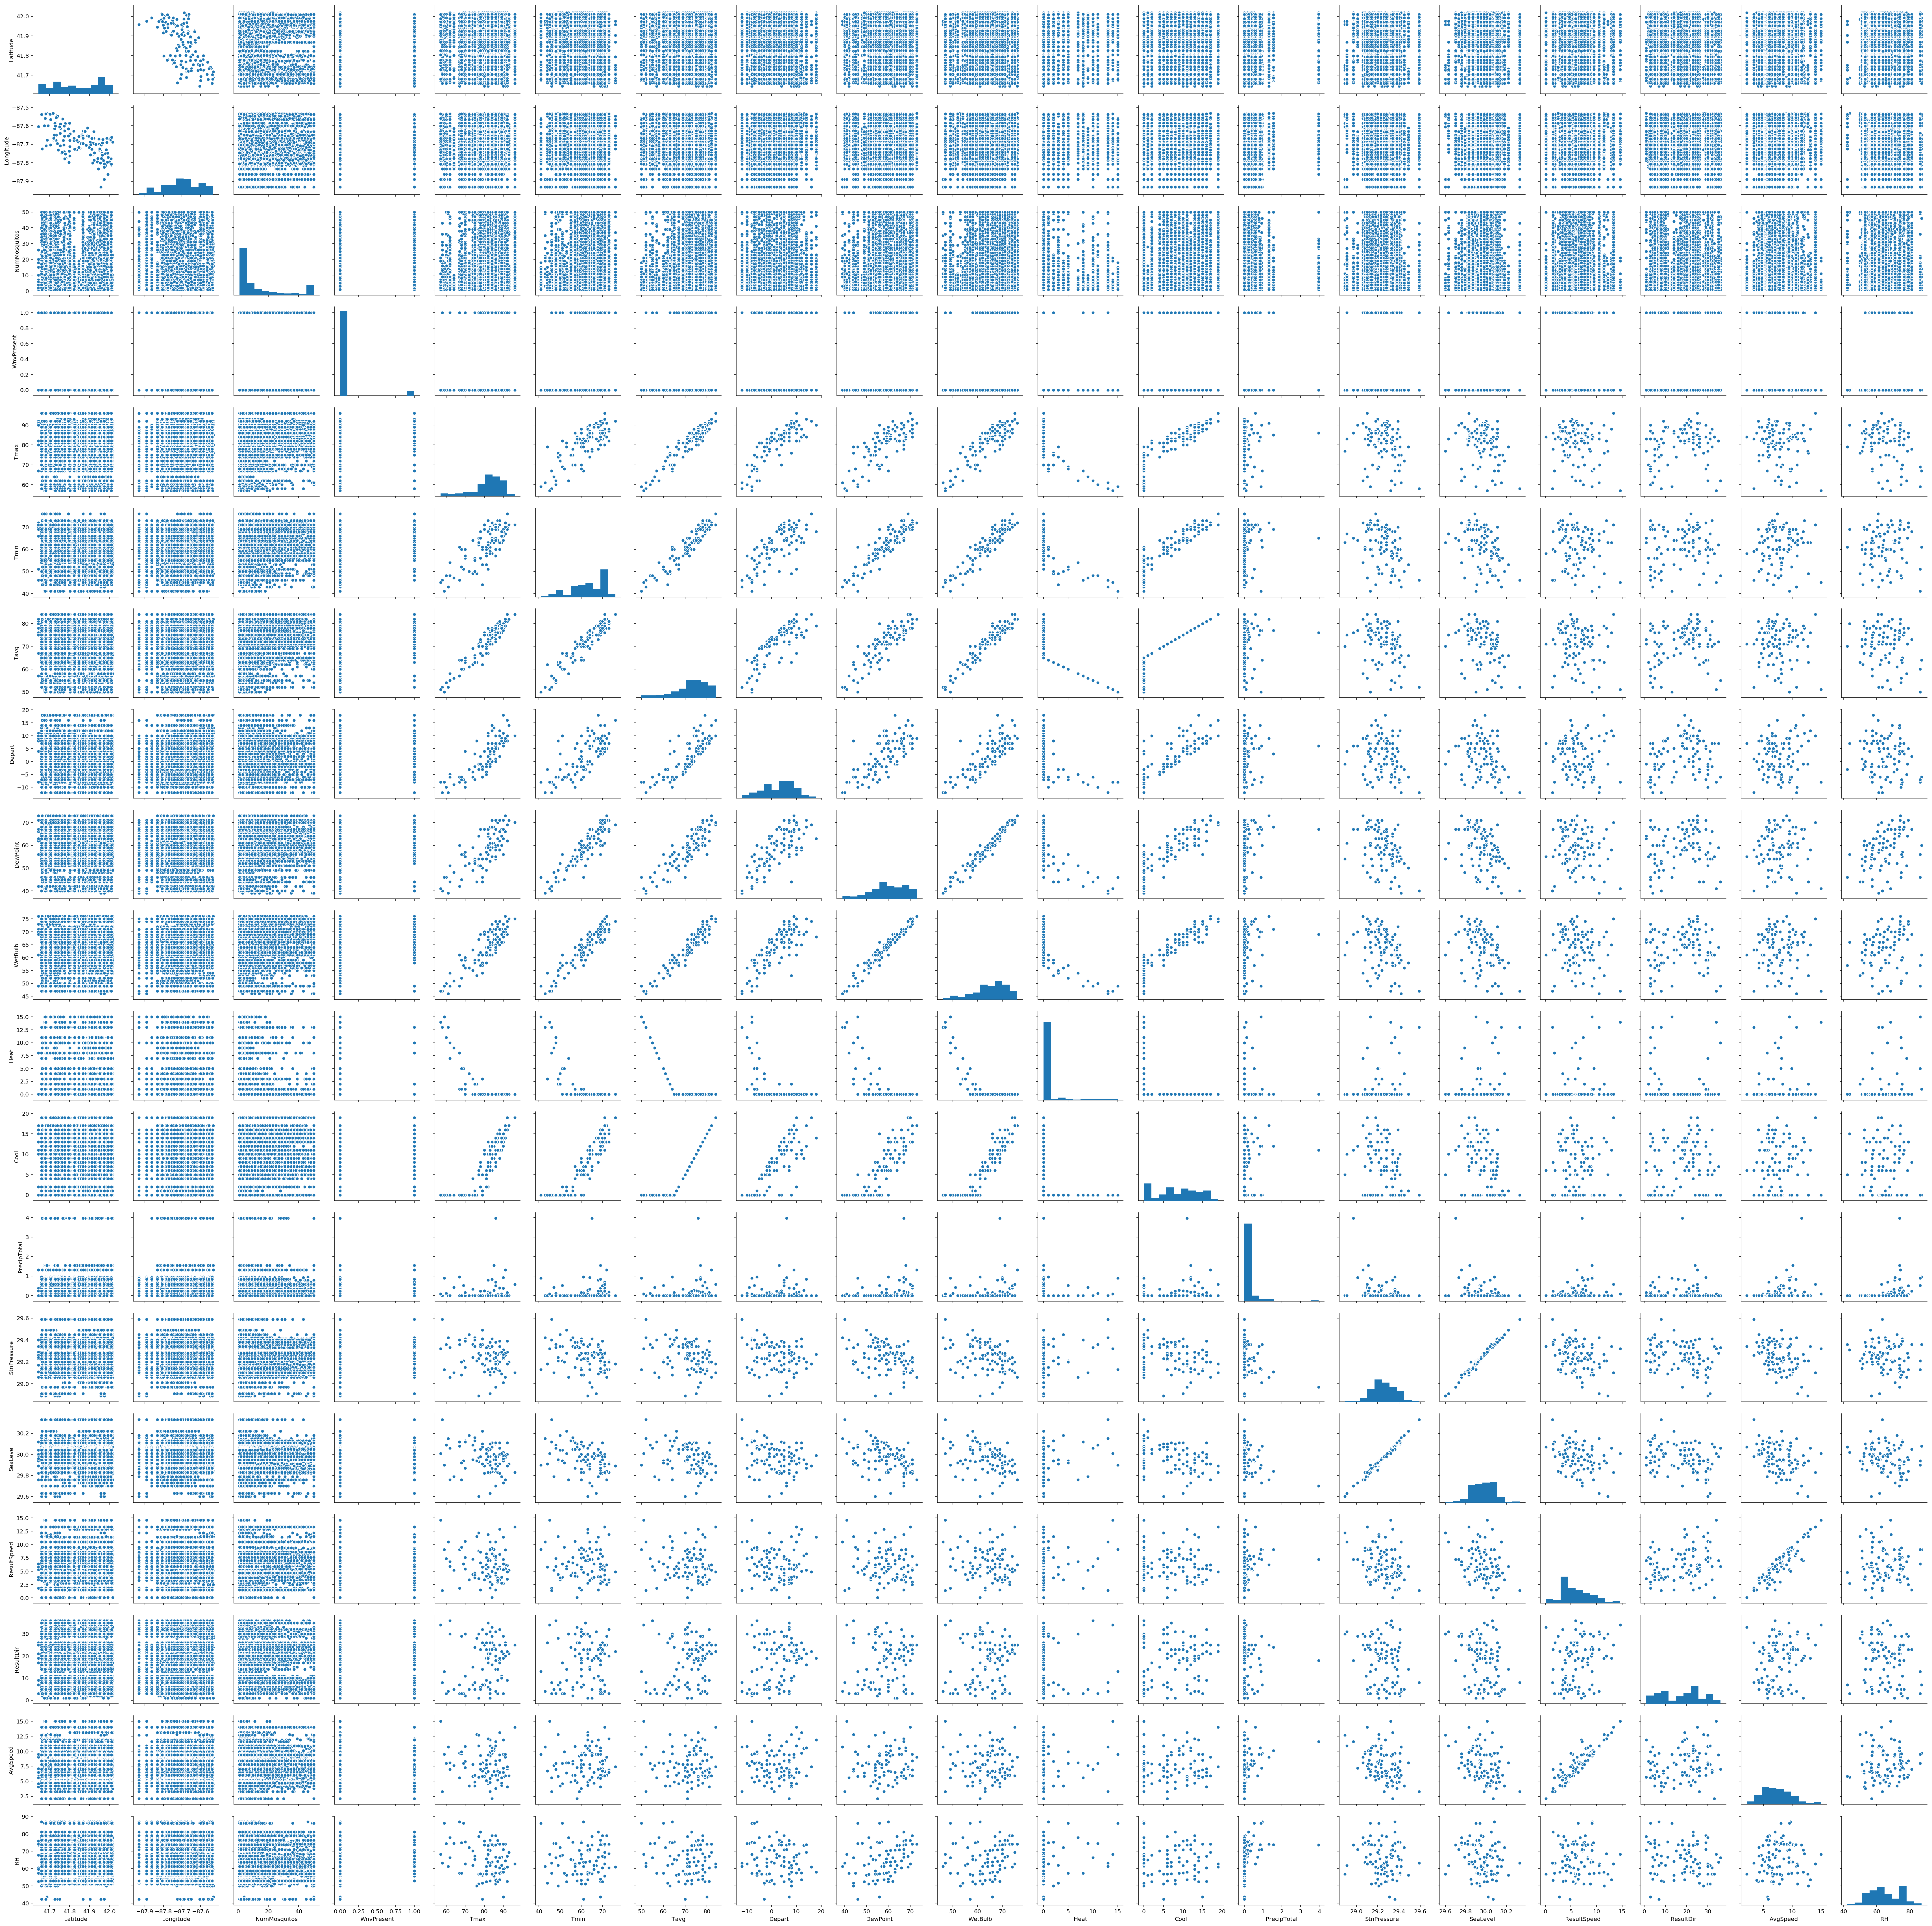

In [160]:
sns.pairplot(train_weather)

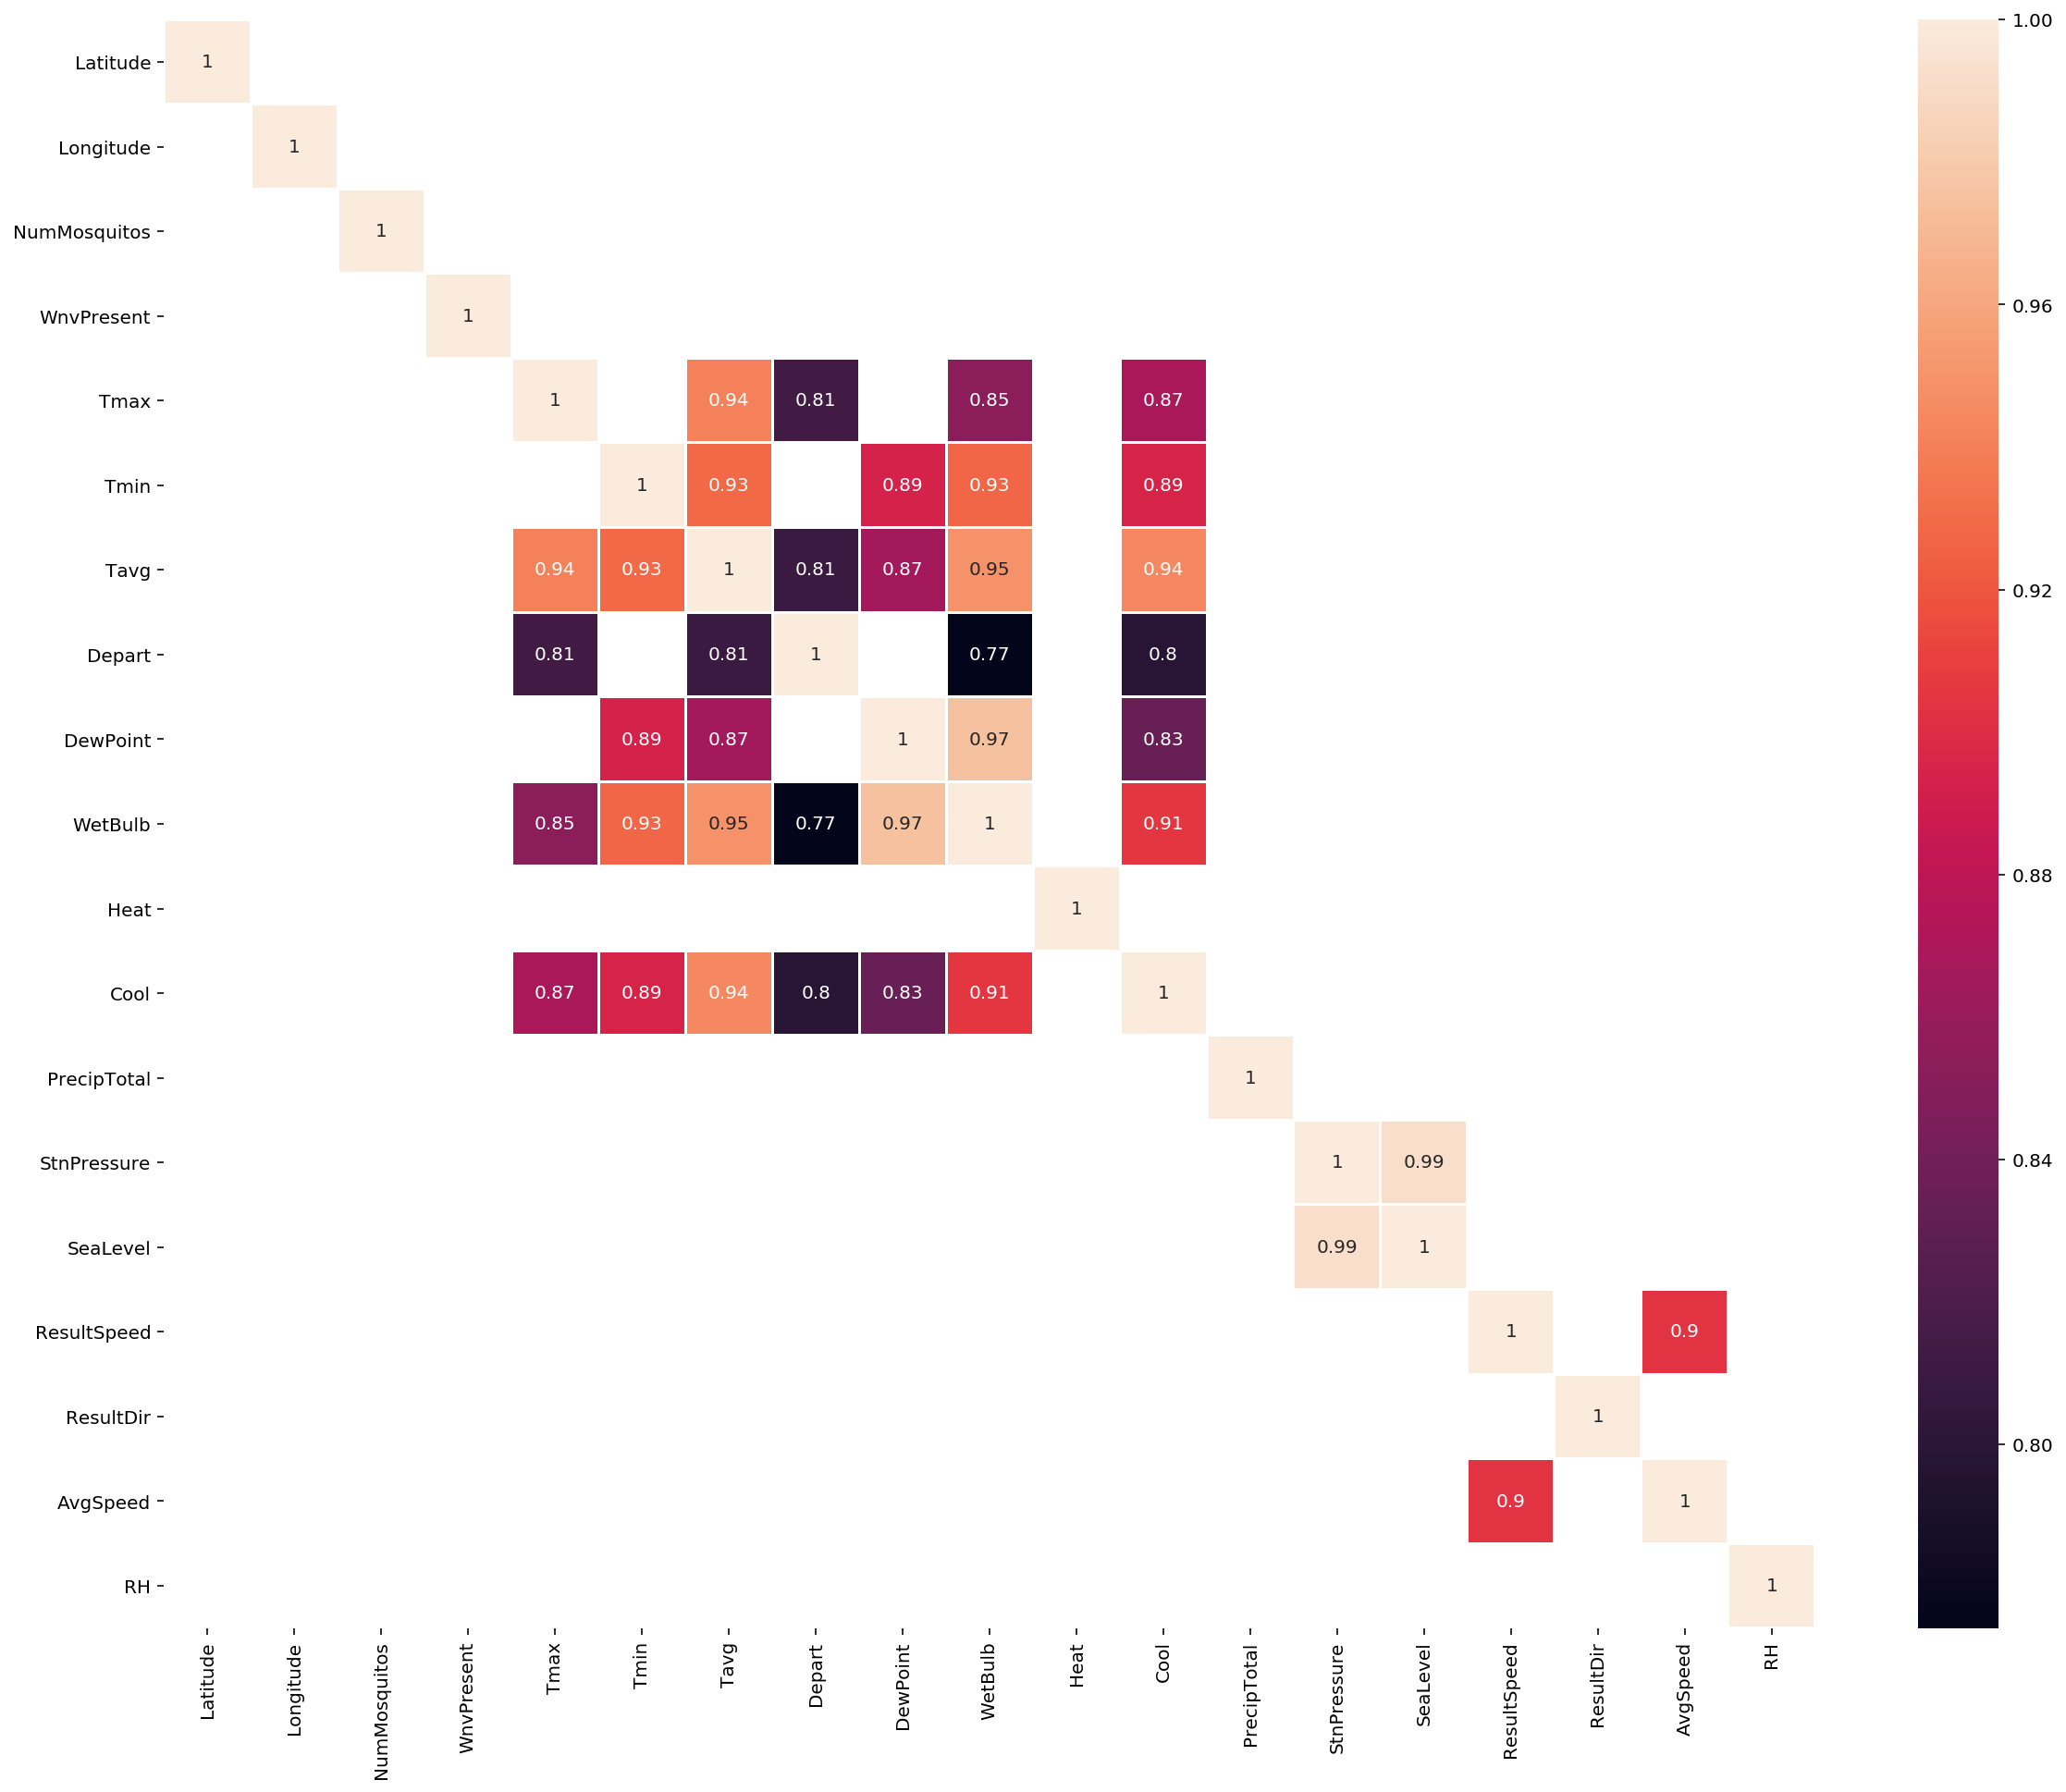

In [69]:
plt.figure(figsize=(20, 16))
sns.heatmap(train_weather.corr()[ train_weather.corr()>0.75 ], annot = True, linewidths = 1)

In [70]:
#! conda install -y -c conda-forge xgboost

In [252]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, classification_report
import sklearn.datasets as datasets

#### Logistic Regression

In [195]:
train_weather.columns

Index(['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'NumMosquitos',
       'WnvPresent', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'RH'],
      dtype='object')

In [196]:
X_drop = ['WnvPresent', 'Species', 'Date', 'Trap', 'Tmin', 'Tmax', 'DewPoint', 'WetBulb',
          'Cool', 'ResultSpeed', 'SeaLevel']
y = LabelEncoder().fit_transform(train_weather['WnvPresent'])
X = pd.concat([train_weather.copy().drop(X_drop, axis=1),
                             pd.get_dummies(train_weather['Species'])], axis =1)
lr = LogisticRegression()
s = cross_val_score(lr, X, y, cv=5, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Logistic Regression", s.mean().round(3), s.std().round(3)))

Logistic Regression Score:	0.947 ± 0.0


#### Random Forest

Random Forest Score:	0.928 ± 0.003


[]

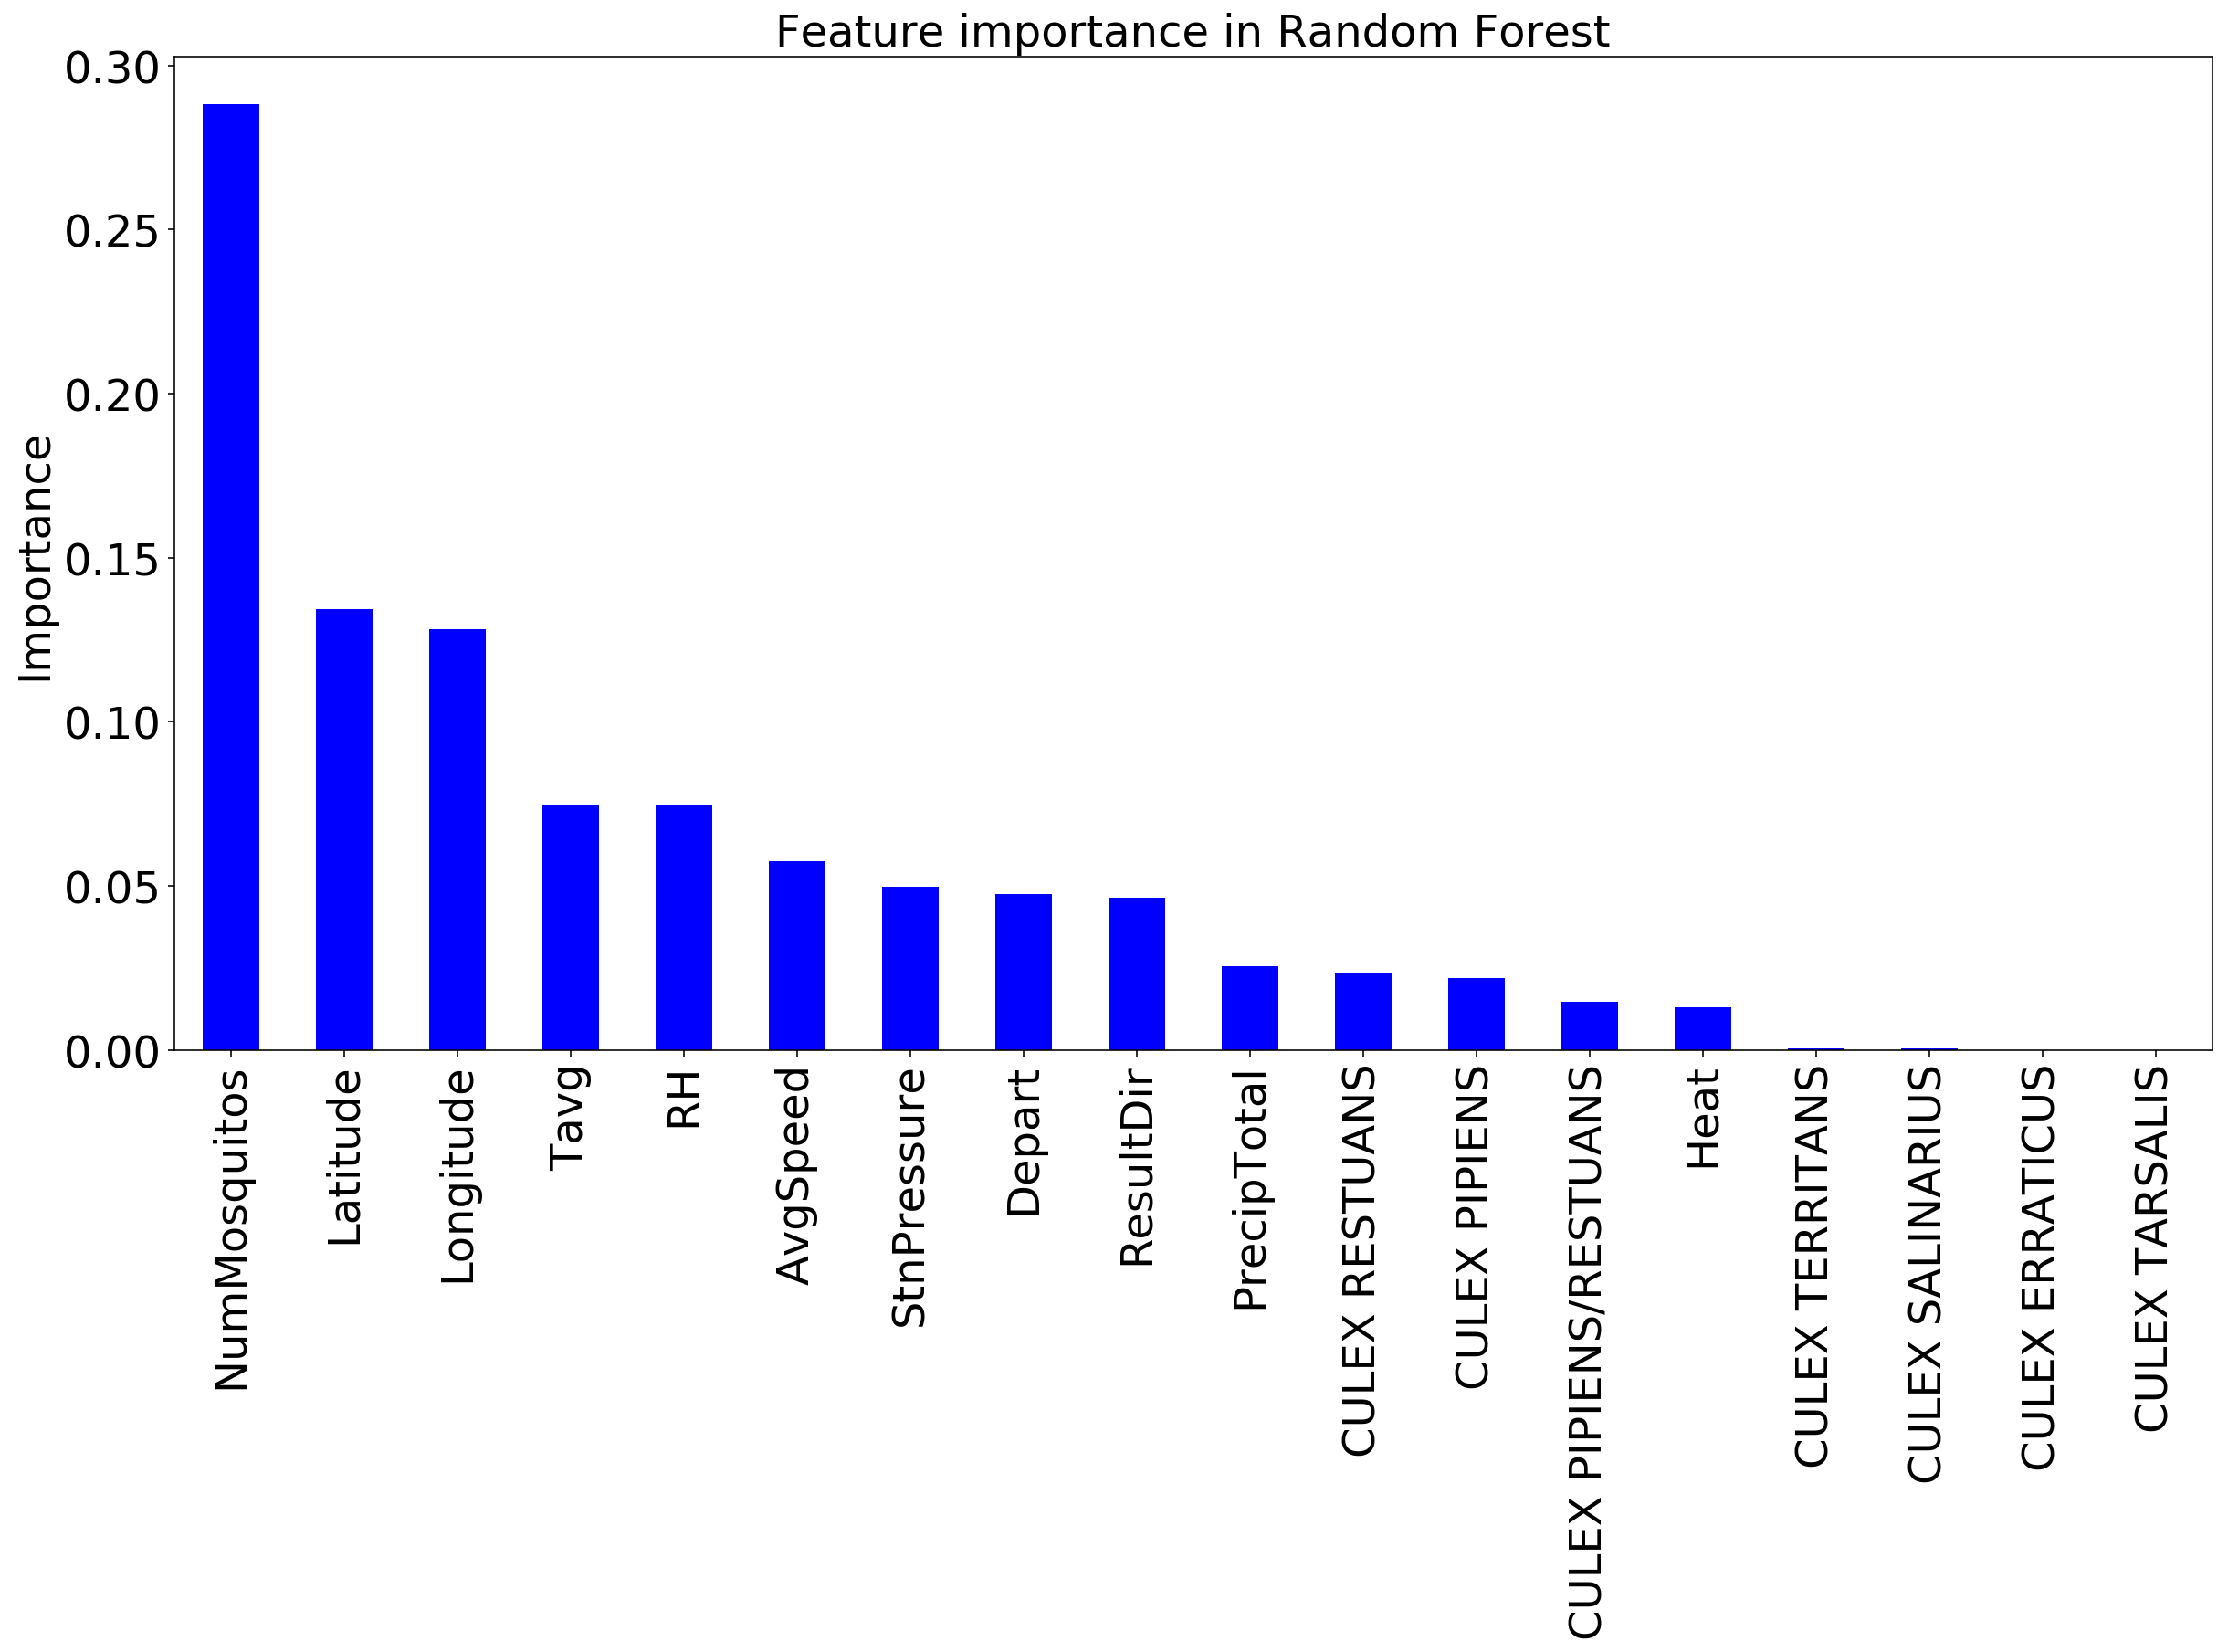

In [313]:
X_drop = ['WnvPresent', 'Species', 'Date', 'Trap', 'Tmin', 'Tmax', 'DewPoint', 'WetBulb',
          'Cool', 'ResultSpeed', 'SeaLevel']
y = LabelEncoder().fit_transform(train_weather['WnvPresent'])
X = pd.concat([train_weather.copy().drop(X_drop, axis=1),
                             pd.get_dummies(train_weather['Species'])], axis =1)

cv = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=42)

rf = RandomForestClassifier(class_weight='balanced')
s = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

rf.fit(X, y)
imp = pd.DataFrame({'importance': list(rf.feature_importances_)}, index=X.columns)
imp.sort_values(by='importance', ascending=False, inplace=True)
imp_top20 = imp.head(20)
imp_top20.sort_values(by='importance', ascending=False, inplace=True)

imp_top20.plot(kind='bar', fontsize=24, figsize=(20,10), legend='', color='b')
plt.xlabel('', fontsize=24)
plt.ylabel('Importance', fontsize=24)
plt.title('Feature importance in Random Forest', fontsize=24)
plt.plot()

In [314]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

ss = StandardScaler()
X_scaled = ss.fit_transform(X_train)
X_scaled_test = ss.transform(X_test)

rf.fit(X_scaled, y_train)

# model evaluation
pred = xgb.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

print(rf.predict(X_scaled_test))
print('Accuracy: %0.3f'%rf.score(X_scaled_test, y_test))

[[3281    4]
 [ 174    8]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      3285
          1       0.67      0.04      0.08       182

avg / total       0.93      0.95      0.93      3467

[0 0 0 ..., 0 0 0]
Accuracy: 0.926


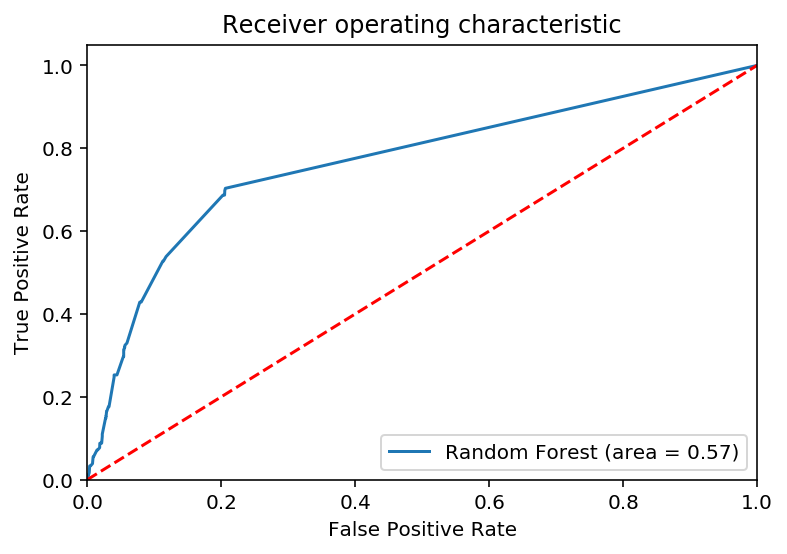

In [315]:
logit_roc_auc = roc_auc_score(y_test, rf.predict(X_scaled_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_scaled_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### XGB

In [255]:
#X_drop = ['WnvPresent', 'Species', 'Date', 'Trap', 'Tmin', 'Tmax', 'DewPoint', 'WetBulb',
#          'Cool', 'ResultSpeed', 'SeaLevel']
#species_not_wnv = ['CULEX TERRITANS', 'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX ERRATICUS']
#y = LabelEncoder().fit_transform(train_weather['WnvPresent'])
#X = pd.concat([train_weather.copy().drop(X_drop, axis=1),
#                             pd.get_dummies(train_weather['Species']).drop(species_not_wnv, axis=1)], axis=1)
X_drop = ['WnvPresent', 'Species', 'Date', 'Trap', 'Tmin', 'Tmax', 'DewPoint', 'WetBulb',
          'Cool', 'ResultSpeed', 'SeaLevel']
y = LabelEncoder().fit_transform(train_weather['WnvPresent'])
X = pd.concat([train_weather.copy().drop(X_drop, axis=1),
                             pd.get_dummies(train_weather['Species'])], axis =1)

XGB Score:	0.947 ± 0.0


[]

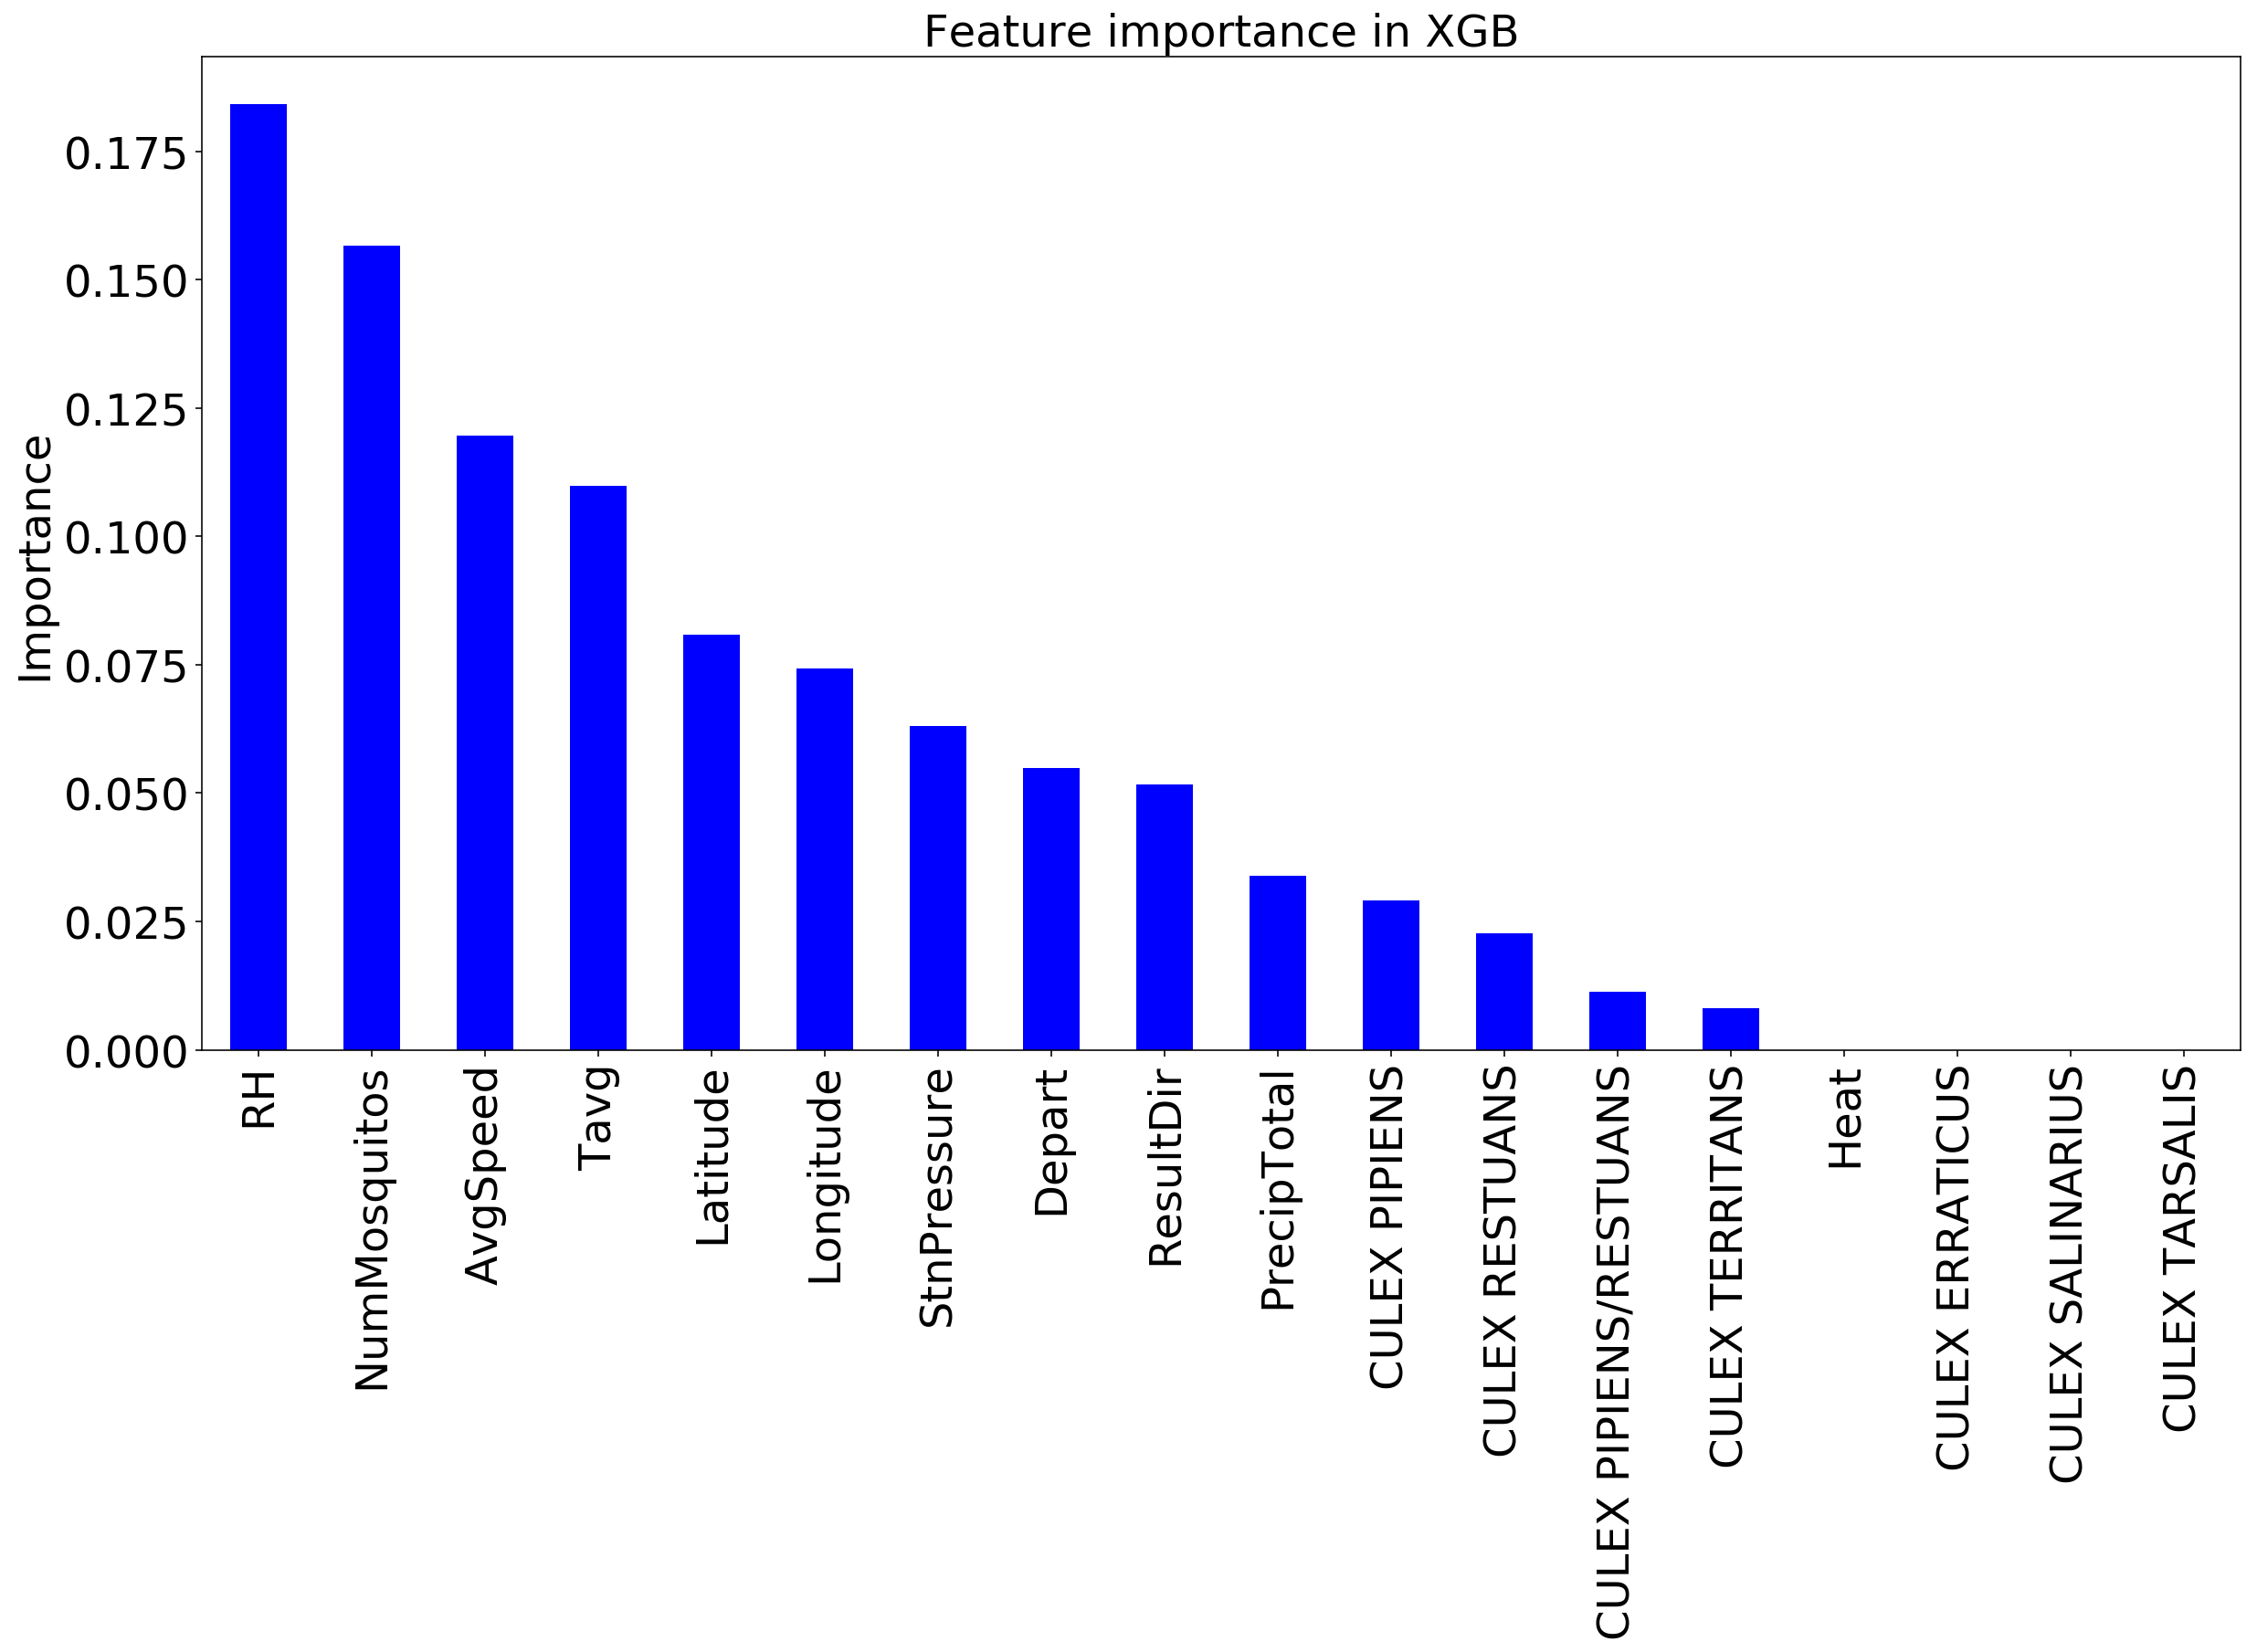

In [256]:
cv = StratifiedKFold(y, n_folds=3, shuffle=True, random_state=42)

#xgb = XGBClassifier(scale_pos_weight=1, objective='binary:logistic')
xgb = XGBClassifier()
s = cross_val_score(xgb, X, y, cv=cv, n_jobs=-1)
print("{} Score:\t{:0.3} ± {:0.3}".format("XGB", s.mean().round(3), s.std().round(3)))

xgb.fit(X, y)

imp = pd.DataFrame({'importance': list(xgb.feature_importances_)}, index=X.columns)
imp.sort_values(by='importance', ascending=False, inplace=True)
imp_top20 = imp.head(20)
imp_top20.sort_values(by='importance', ascending=False, inplace=True)

imp_top20.plot(kind='bar', fontsize=24, figsize=(20,10), legend='', color='b')
plt.xlabel('', fontsize=24)
plt.ylabel('Importance', fontsize=24)
plt.title('Feature importance in XGB', fontsize=24)
plt.plot()

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

ss = StandardScaler()
X_scaled = ss.fit_transform(X_train)
X_scaled_test = ss.transform(X_test)

xgb = XGBClassifier(scale_pos_weight=1, objective='binary:logistic')
xgb.fit(X_scaled, y_train)

print(xgb.predict(X_scaled_test))
print('Accuracy: %0.3f'%xgb.score(X_scaled_test, y_test))

[0 0 0 ..., 0 0 0]
Accuracy: 0.948


In [258]:
xgb.predict

<bound method XGBClassifier.predict of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)>

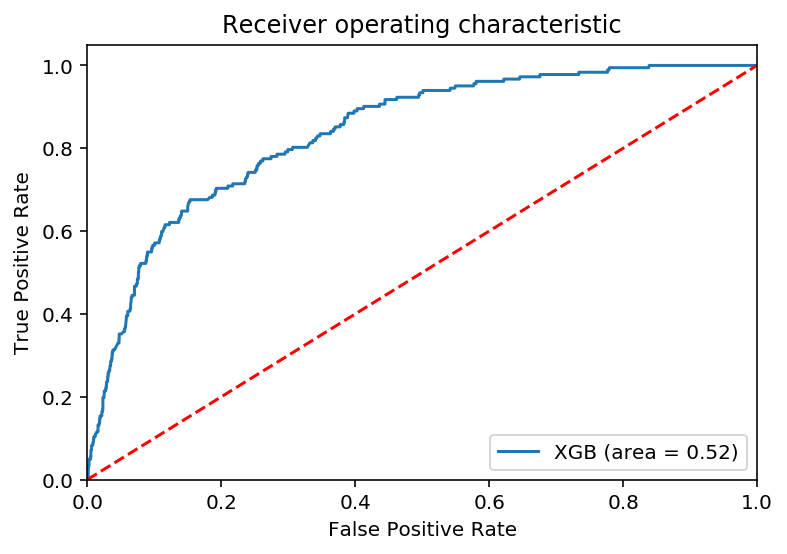

In [259]:
logit_roc_auc = roc_auc_score(y_test, xgb.predict(X_scaled_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_scaled_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGB (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [206]:
results = cross_val_score(xgb, X_scaled_test, y_test, cv=10, scoring='accuracy').mean()
results

0.94721709396505305

In [207]:
xgb.predict(X_scaled_test)

array([0, 0, 0, ..., 0, 0, 0])

#### XGB1

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   48.4s finished


{'max_depth': 2, 'n_estimators': 200} 0.948055480011
[[2982    4]
 [ 160    6]]
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      2986
          1       0.60      0.04      0.07       166

avg / total       0.93      0.95      0.93      3152



[]

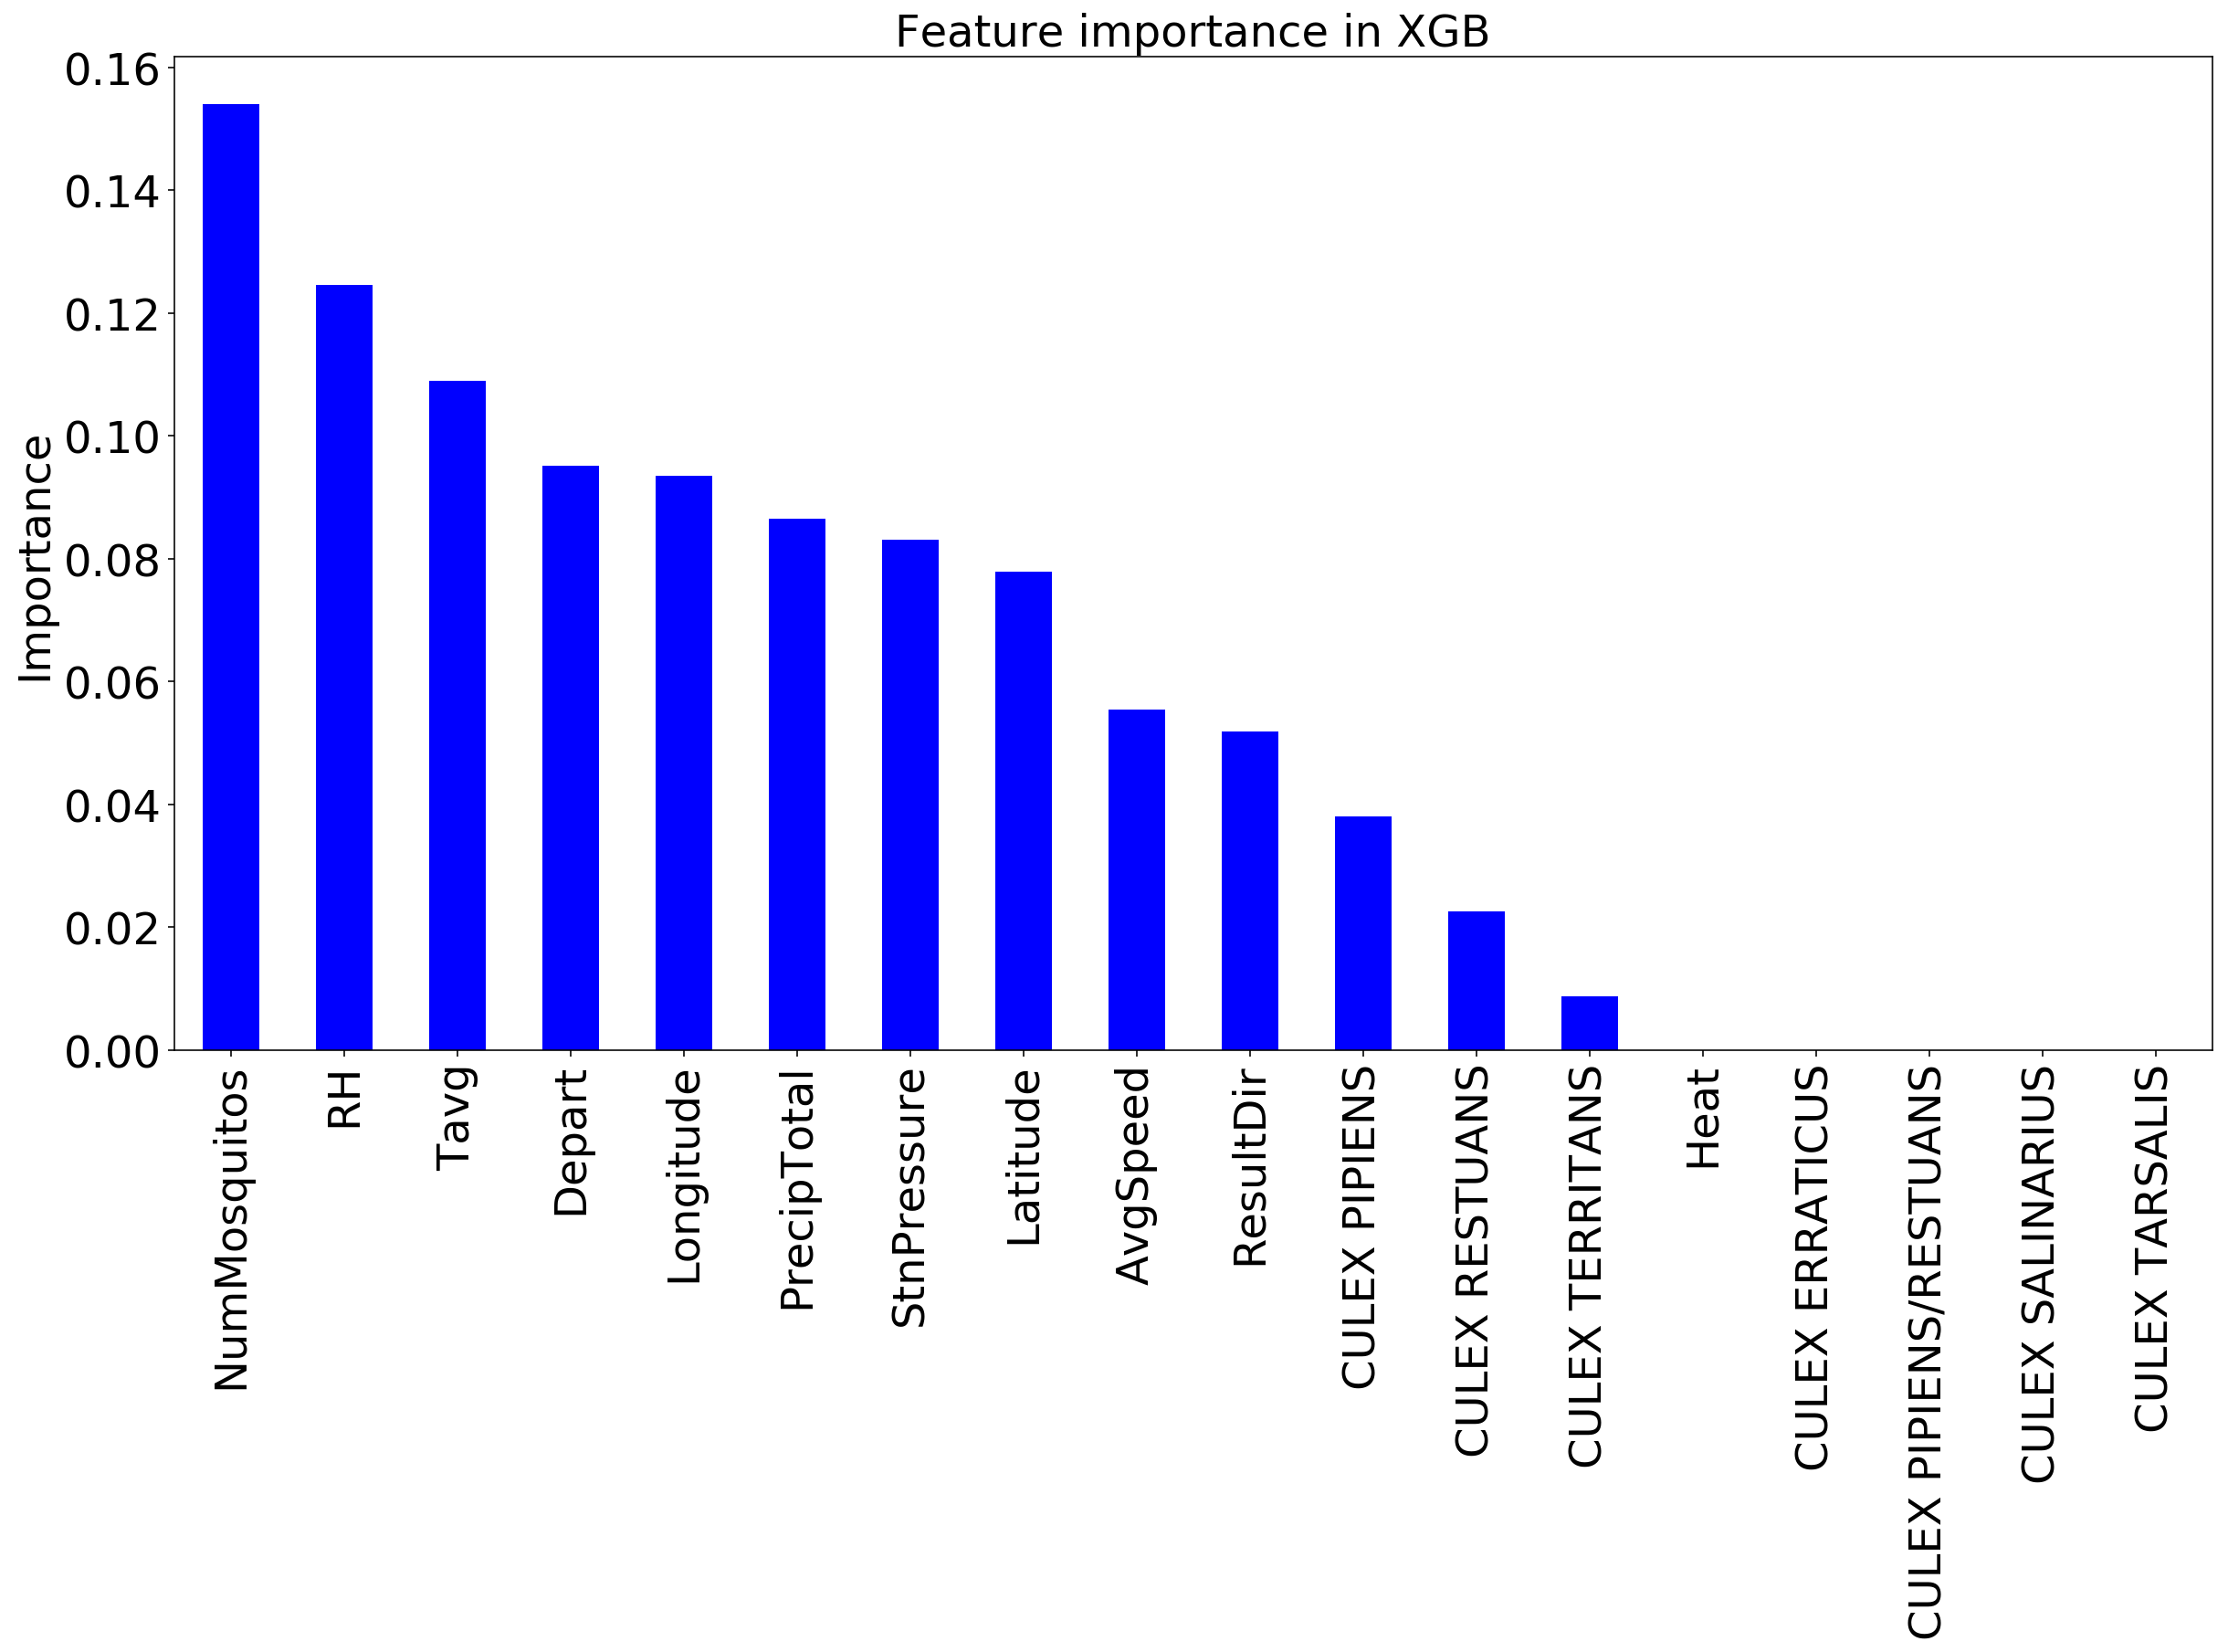

In [319]:
X_drop = ['WnvPresent', 'Species', 'Date', 'Trap', 'Tmin', 'Tmax', 'DewPoint', 'WetBulb',
          'Cool', 'ResultSpeed', 'SeaLevel']
y = LabelEncoder().fit_transform(train_weather['WnvPresent'])
X = pd.concat([train_weather.copy().drop(X_drop, axis=1),
                             pd.get_dummies(train_weather['Species'])], axis =1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

ss = StandardScaler()
X_scaled_train = ss.fit_transform(X_train)
X_scaled_test = ss.transform(X_test)

xgb = XGBClassifier(objective='binary:logistic', max_depth=10)

xgb_cv = GridSearchCV(xgb, {'max_depth': [2,4,6,10], 'n_estimators': [50,100,200,300]}, verbose=1)
xgb_cv.fit(X_scaled_train, y_train)
print(xgb_cv.best_params_, xgb_cv.best_score_)

# hyperparameter search
xgb = XGBClassifier(**xgb_cv.best_params_, objective='binary:logistic')

# refit with the hyperparameters
xgb.fit(X_scaled_train, y_train)

# model evaluation
pred = xgb.predict(X_scaled_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

imp = pd.DataFrame({'importance': list(xgb.feature_importances_)}, index=X.columns)
imp.sort_values(by='importance', ascending=False, inplace=True)
imp_top20 = imp.head(20)
imp_top20.sort_values(by='importance', ascending=False, inplace=True)

imp_top20.plot(kind='bar', fontsize=24, figsize=(20,10), legend='', color='b')
plt.xlabel('', fontsize=24)
plt.ylabel('Importance', fontsize=24)
plt.title('Feature importance in XGB', fontsize=24)
plt.plot()

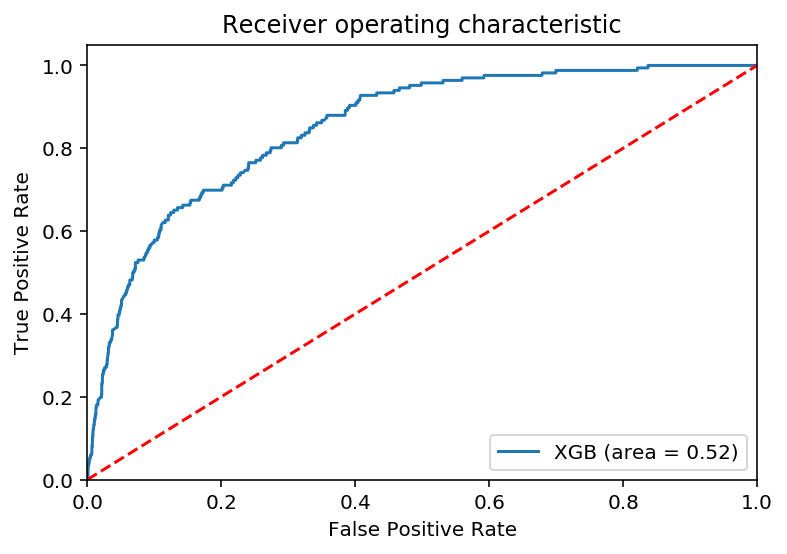

In [320]:
logit_roc_auc = roc_auc_score(y_test, xgb.predict(X_scaled_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_scaled_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGB (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [262]:
def eval_sklearn_model(y_true, predictions, model=None, X=None):
    """This function takes the true values for y and the predictions made by the model and prints
    out the confusion matrix along with Accuracy, Precision, and, if model and X provided, Roc_Auc Scores."""
    cnf_matrix = confusion_matrix(y_true, predictions)

    print('True Negative: ', cnf_matrix[0, 0], '| False Positive: ', cnf_matrix[0, 1])
    print('False Negative: ', cnf_matrix[1, 0], '| True Positive: ', cnf_matrix[1, 1], '\n')

    sensitivity = cnf_matrix[1, 1]/ (cnf_matrix[1, 0] + cnf_matrix[1, 1])
    specificity = cnf_matrix[0, 0]/ (cnf_matrix[0, 1] + cnf_matrix[0, 0])

    print('Sensitivity (TP/ TP + FN): ', sensitivity)
    print('Specificity (TN/ TN + FP): ', specificity, '\n')

    print('Accuracy: ', accuracy_score(y_true, predictions, normalize=True))
    print('Precision: ', precision_score(y_true, predictions))
    if model != None:
        print('Roc-Auc: ', roc_auc_score(y_true, [x[1] for x in model.predict_proba(X)]))
    else:
        pass
    print('\n')

In [251]:
test_predictions = xgb.predict(X_test)
eval_sklearn_model(y_test, test_predictions, model=xgb, X=X_test)

True Negative:  1651 | False Positive:  1335
False Negative:  13 | True Positive:  153 

Sensitivity (TP/ TP + FN):  0.921686746988
Specificity (TN/ TN + FP):  0.552913596785 

Accuracy:  0.572335025381
Precision:  0.102822580645
Roc-Auc:  0.855320814403




In [128]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

In [129]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7039, 14)
(7039,)
(3467, 14)
(3467,)


In [130]:
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()

In [134]:
model = Sequential()
model.add(Dense(2048, input_shape=(14,)))
model.add(Activation('relu'))
                           
model.add(Dropout(0.2))   # Dropout helps protect the model from memorizing or "overfitting" the training data
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [135]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', ])

In [136]:
model.fit(X_train, y_train, epochs=20,
          verbose=1, validation_data=(X_test, y_test), class_weight={0:1, 1:6})

Train on 7039 samples, validate on 3467 samples
Epoch 1/20
7039/7039 [==============================] - 7s 999us/step - loss: 5.0511 - acc: 0.9456 - val_loss: 0.8461 - val_acc: 0.9475
Epoch 2/20
7039/7039 [==============================] - 6s 849us/step - loss: 5.0697 - acc: 0.9476 - val_loss: 0.8461 - val_acc: 0.9475
Epoch 3/20
7039/7039 [==============================] - 6s 834us/step - loss: 5.0697 - acc: 0.9476 - val_loss: 0.8461 - val_acc: 0.9475
Epoch 4/20
7039/7039 [==============================] - 6s 857us/step - loss: 5.0697 - acc: 0.9476 - val_loss: 0.8461 - val_acc: 0.9475
Epoch 5/20
7039/7039 [==============================] - 7s 941us/step - loss: 5.0697 - acc: 0.9476 - val_loss: 0.8461 - val_acc: 0.9475
Epoch 6/20
7039/7039 [==============================] - 6s 909us/step - loss: 5.0697 - acc: 0.9476 - val_loss: 0.8461 - val_acc: 0.9475
Epoch 7/20
7039/7039 [==============================] - 7s 951us/step - loss: 5.0697 - acc: 0.9476 - val_loss: 0.8461 - val_acc: 0.9475


In [159]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test score:', score)
print('Test metric:', model.metrics_names)

3467/3467 [==============================] - 0s 106us/step
Test score: [0.84611868864804074, 0.94750504759157772]
Test metric: ['loss', 'acc']


In [153]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

In [154]:
# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes.reshape(3467,) == np.array(y_test))[0]
incorrect_indices = np.nonzero(predicted_classes.reshape(3467,) != np.array(y_test))[0]

In [155]:
true_pos = ((predicted_classes.reshape(3467,) == np.array(y_test)) & (np.array(y_test) == 1)).sum()
true_neg = ((predicted_classes.reshape(3467,) == np.array(y_test)) & (np.array(y_test) == 0)).sum()

In [156]:
false_pos = ((predicted_classes.reshape(3467,) != np.array(y_test)) & (np.array(y_test) == 1)).sum()
false_neg = ((predicted_classes.reshape(3467,) != np.array(y_test)) & (np.array(y_test) == 0)).sum()

In [157]:
print('True Negative: ', true_neg, '| False Positive: ', false_pos)
print('False Negative: ', false_neg, '| True Positive: ', true_pos, '\n')
sensitivity = true_pos/ (true_pos + false_neg)
specificity = true_neg/ (true_neg + false_pos)
print('Sensitivity (TP/ TP + FN): ', sensitivity)
print('Specificity (TN/ TN + FP): ', specificity)

True Negative:  3285 | False Positive:  182
False Negative:  0 | True Positive:  0 

Sensitivity (TP/ TP + FN):  nan
Specificity (TN/ TN + FP):  0.947505047592


/Users/lee/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [158]:
print('True Negative: ', true_neg, '| False Positive: ', false_pos)
print('False Negative: ', false_neg, '| True Positive: ', true_pos, '\n')
sensitivity = true_pos/ (true_pos + false_neg)
specificity = true_neg/ (true_neg + false_pos)
print('Sensitivity (TP/ TP + FN): ', sensitivity)
print('Specificity (TN/ TN + FP): ', specificity)

True Negative:  3285 | False Positive:  182
False Negative:  0 | True Positive:  0 

Sensitivity (TP/ TP + FN):  nan
Specificity (TN/ TN + FP):  0.947505047592


/Users/lee/miniconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
df_train['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [78]:
df_test['Species'].value_counts()

CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
CULEX ERRATICUS           14345
UNSPECIFIED CULEX         14345
Name: Species, dtype: int64

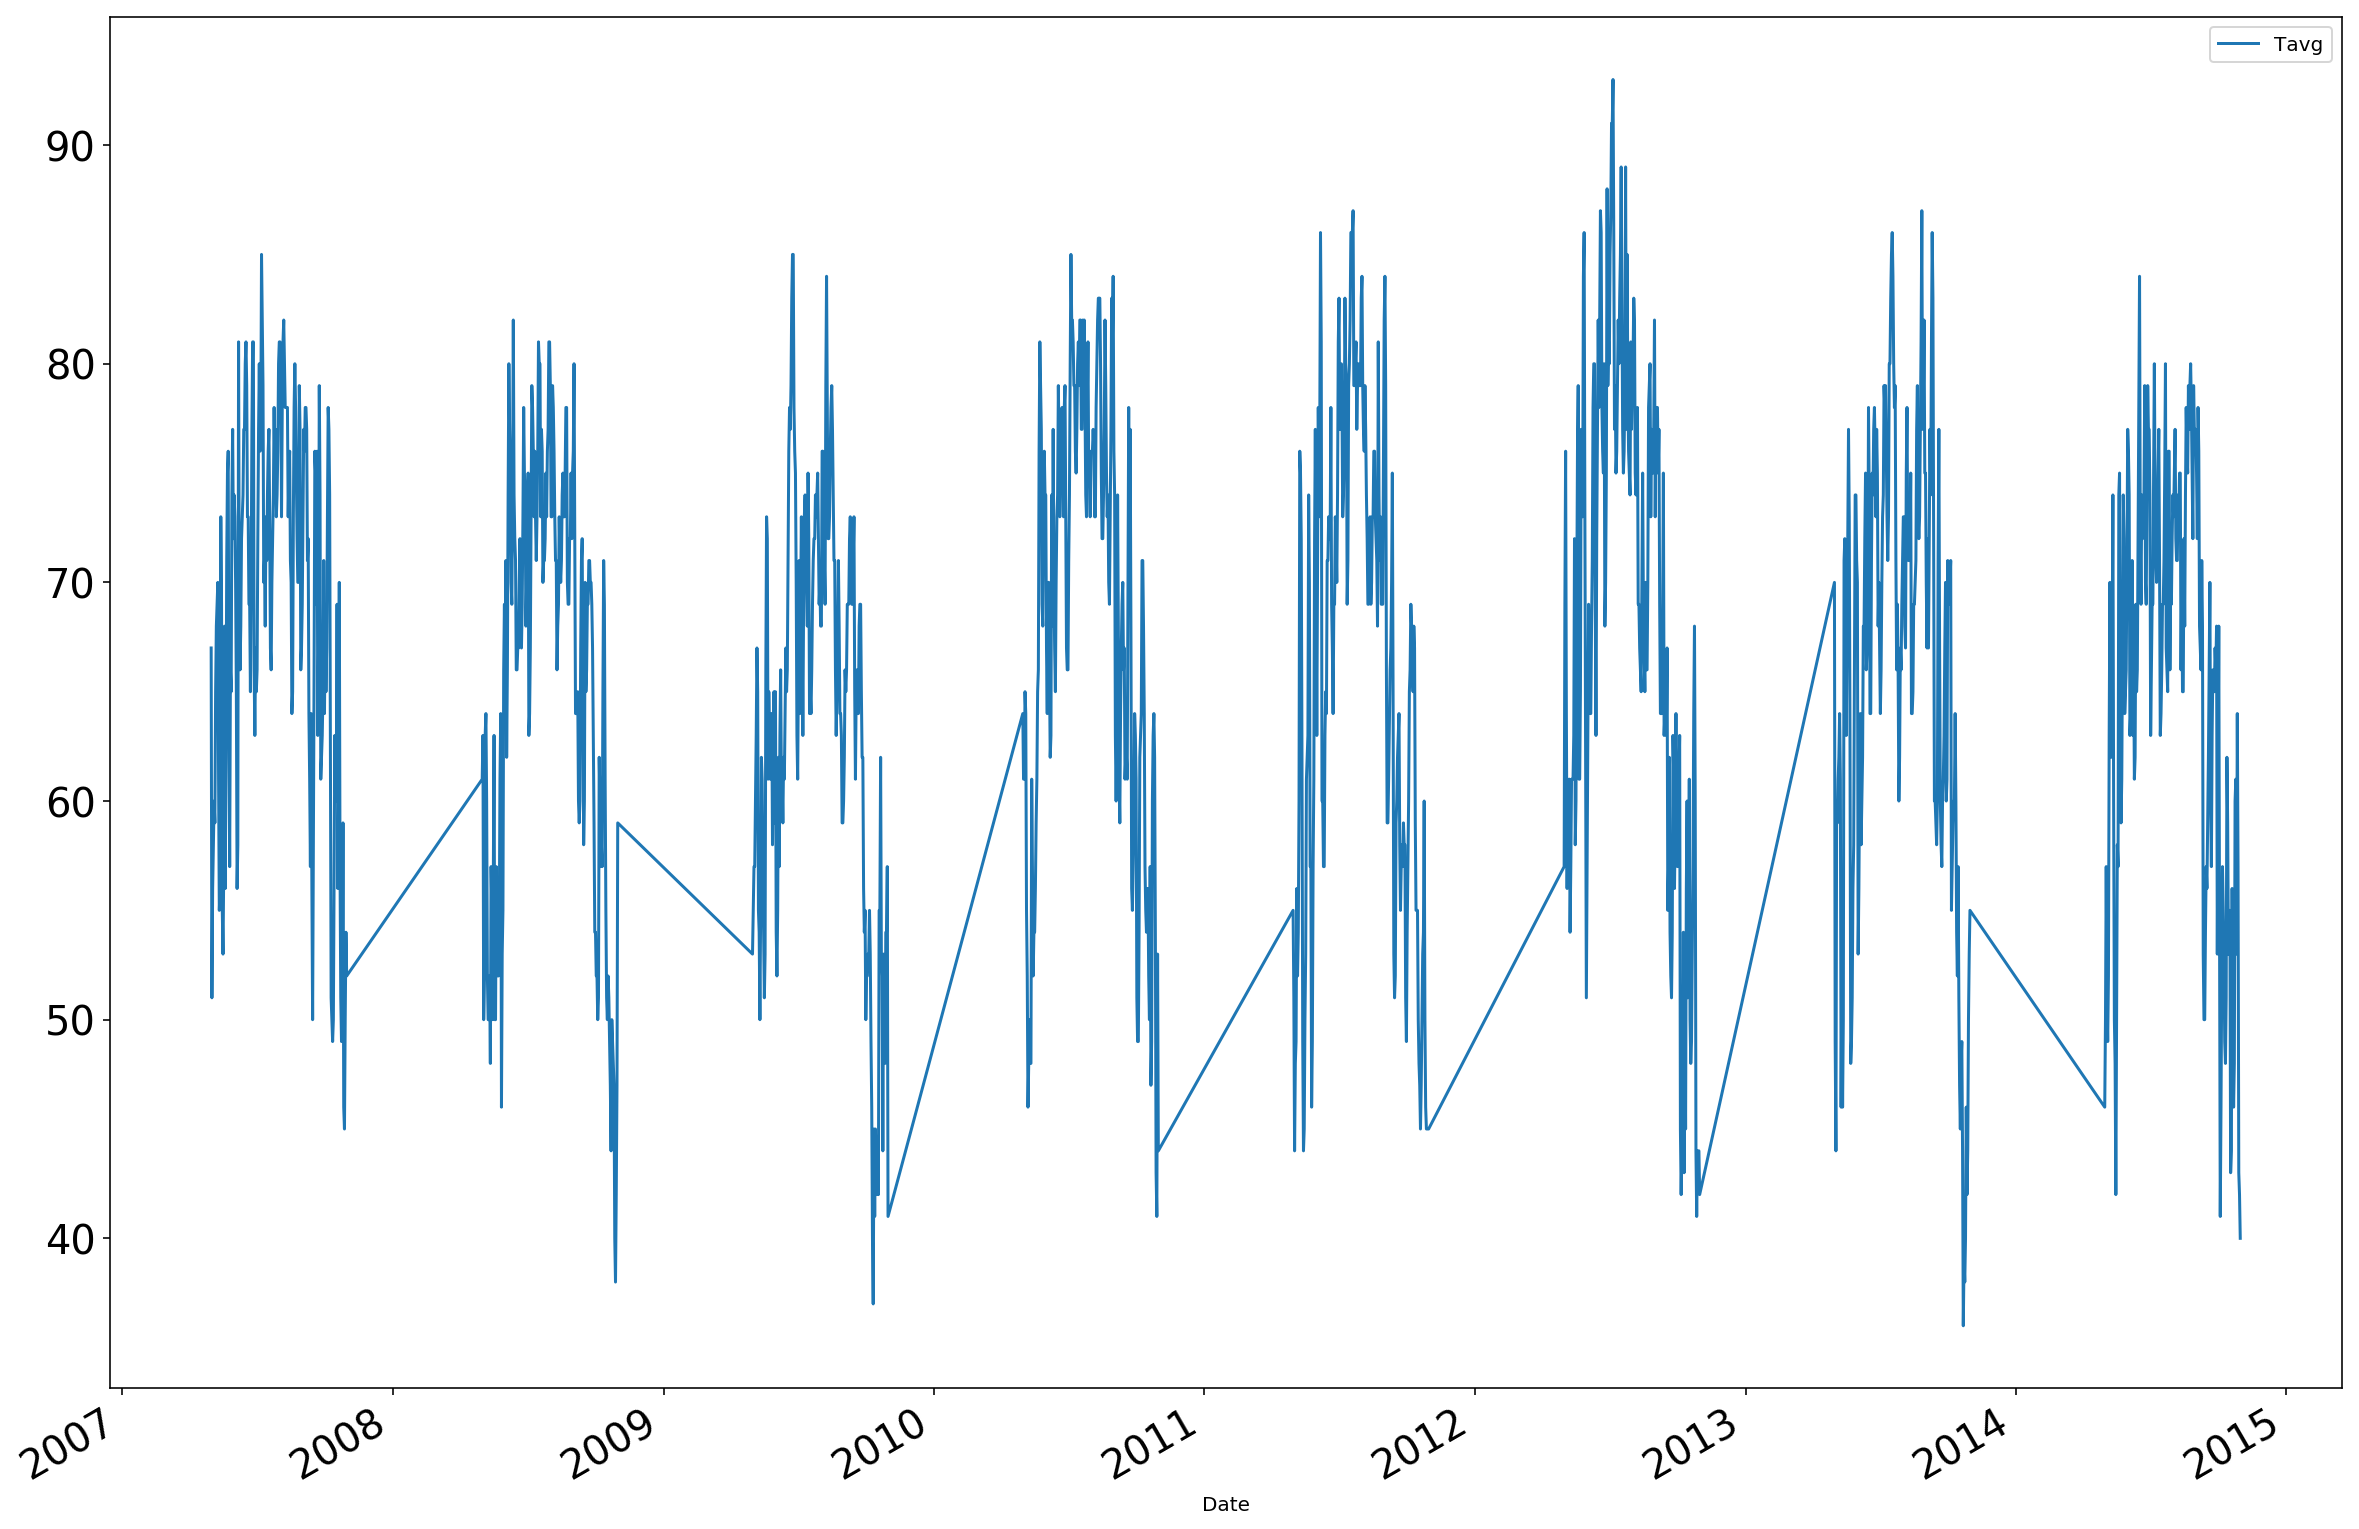

In [300]:
weather.plot('Date', 'Tavg', figsize=(20,14), fontsize=20)

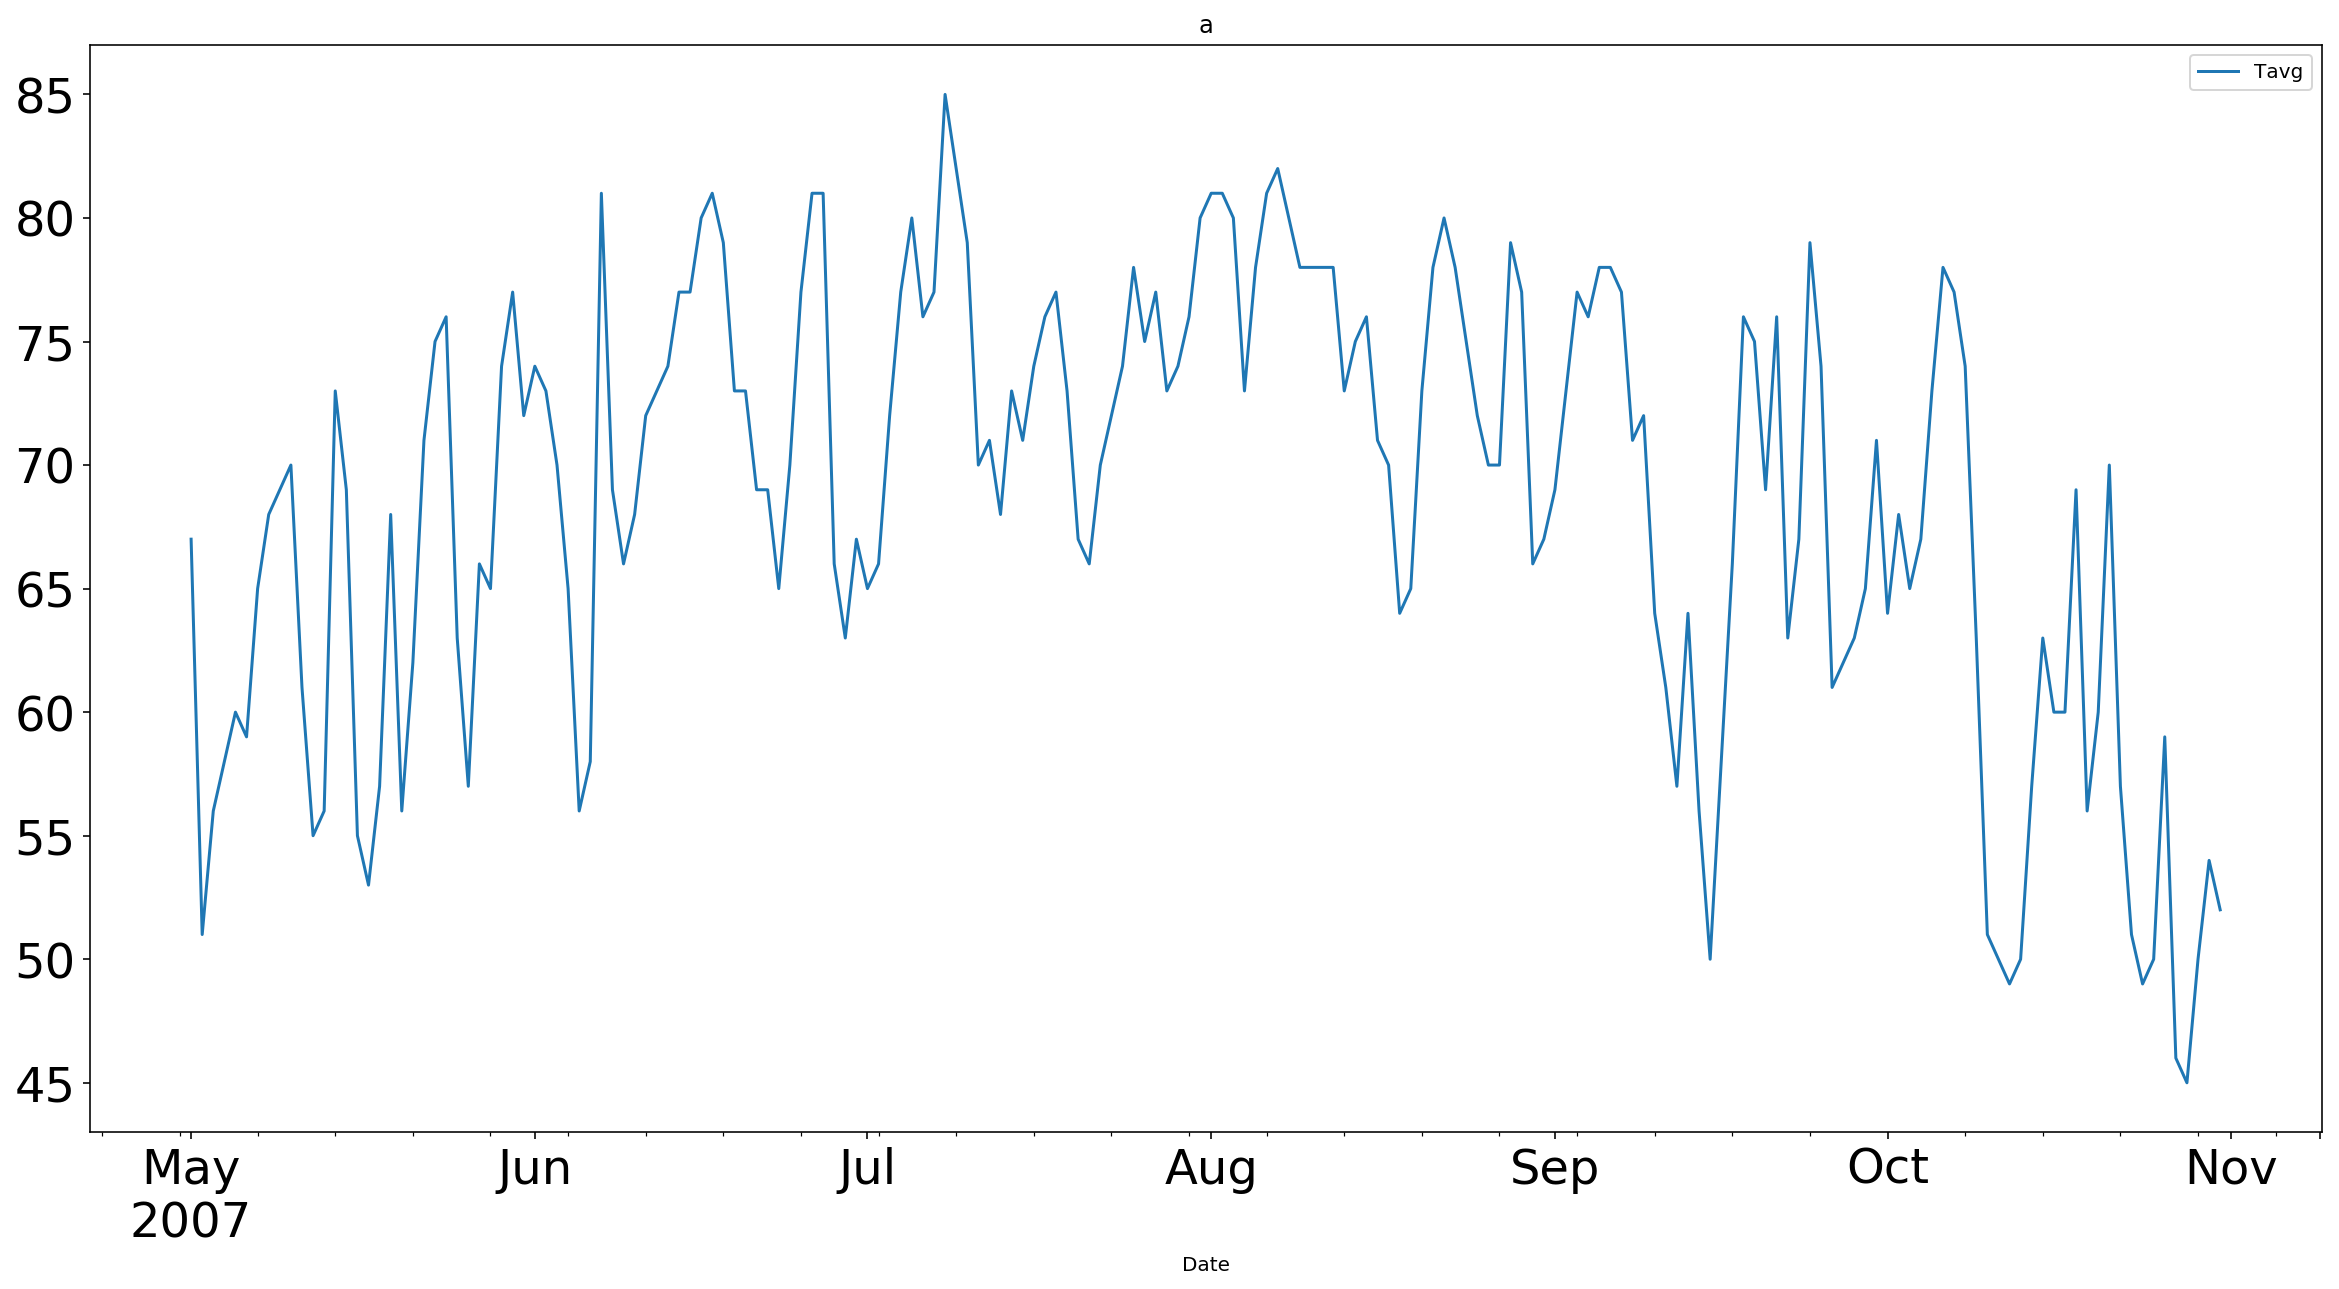

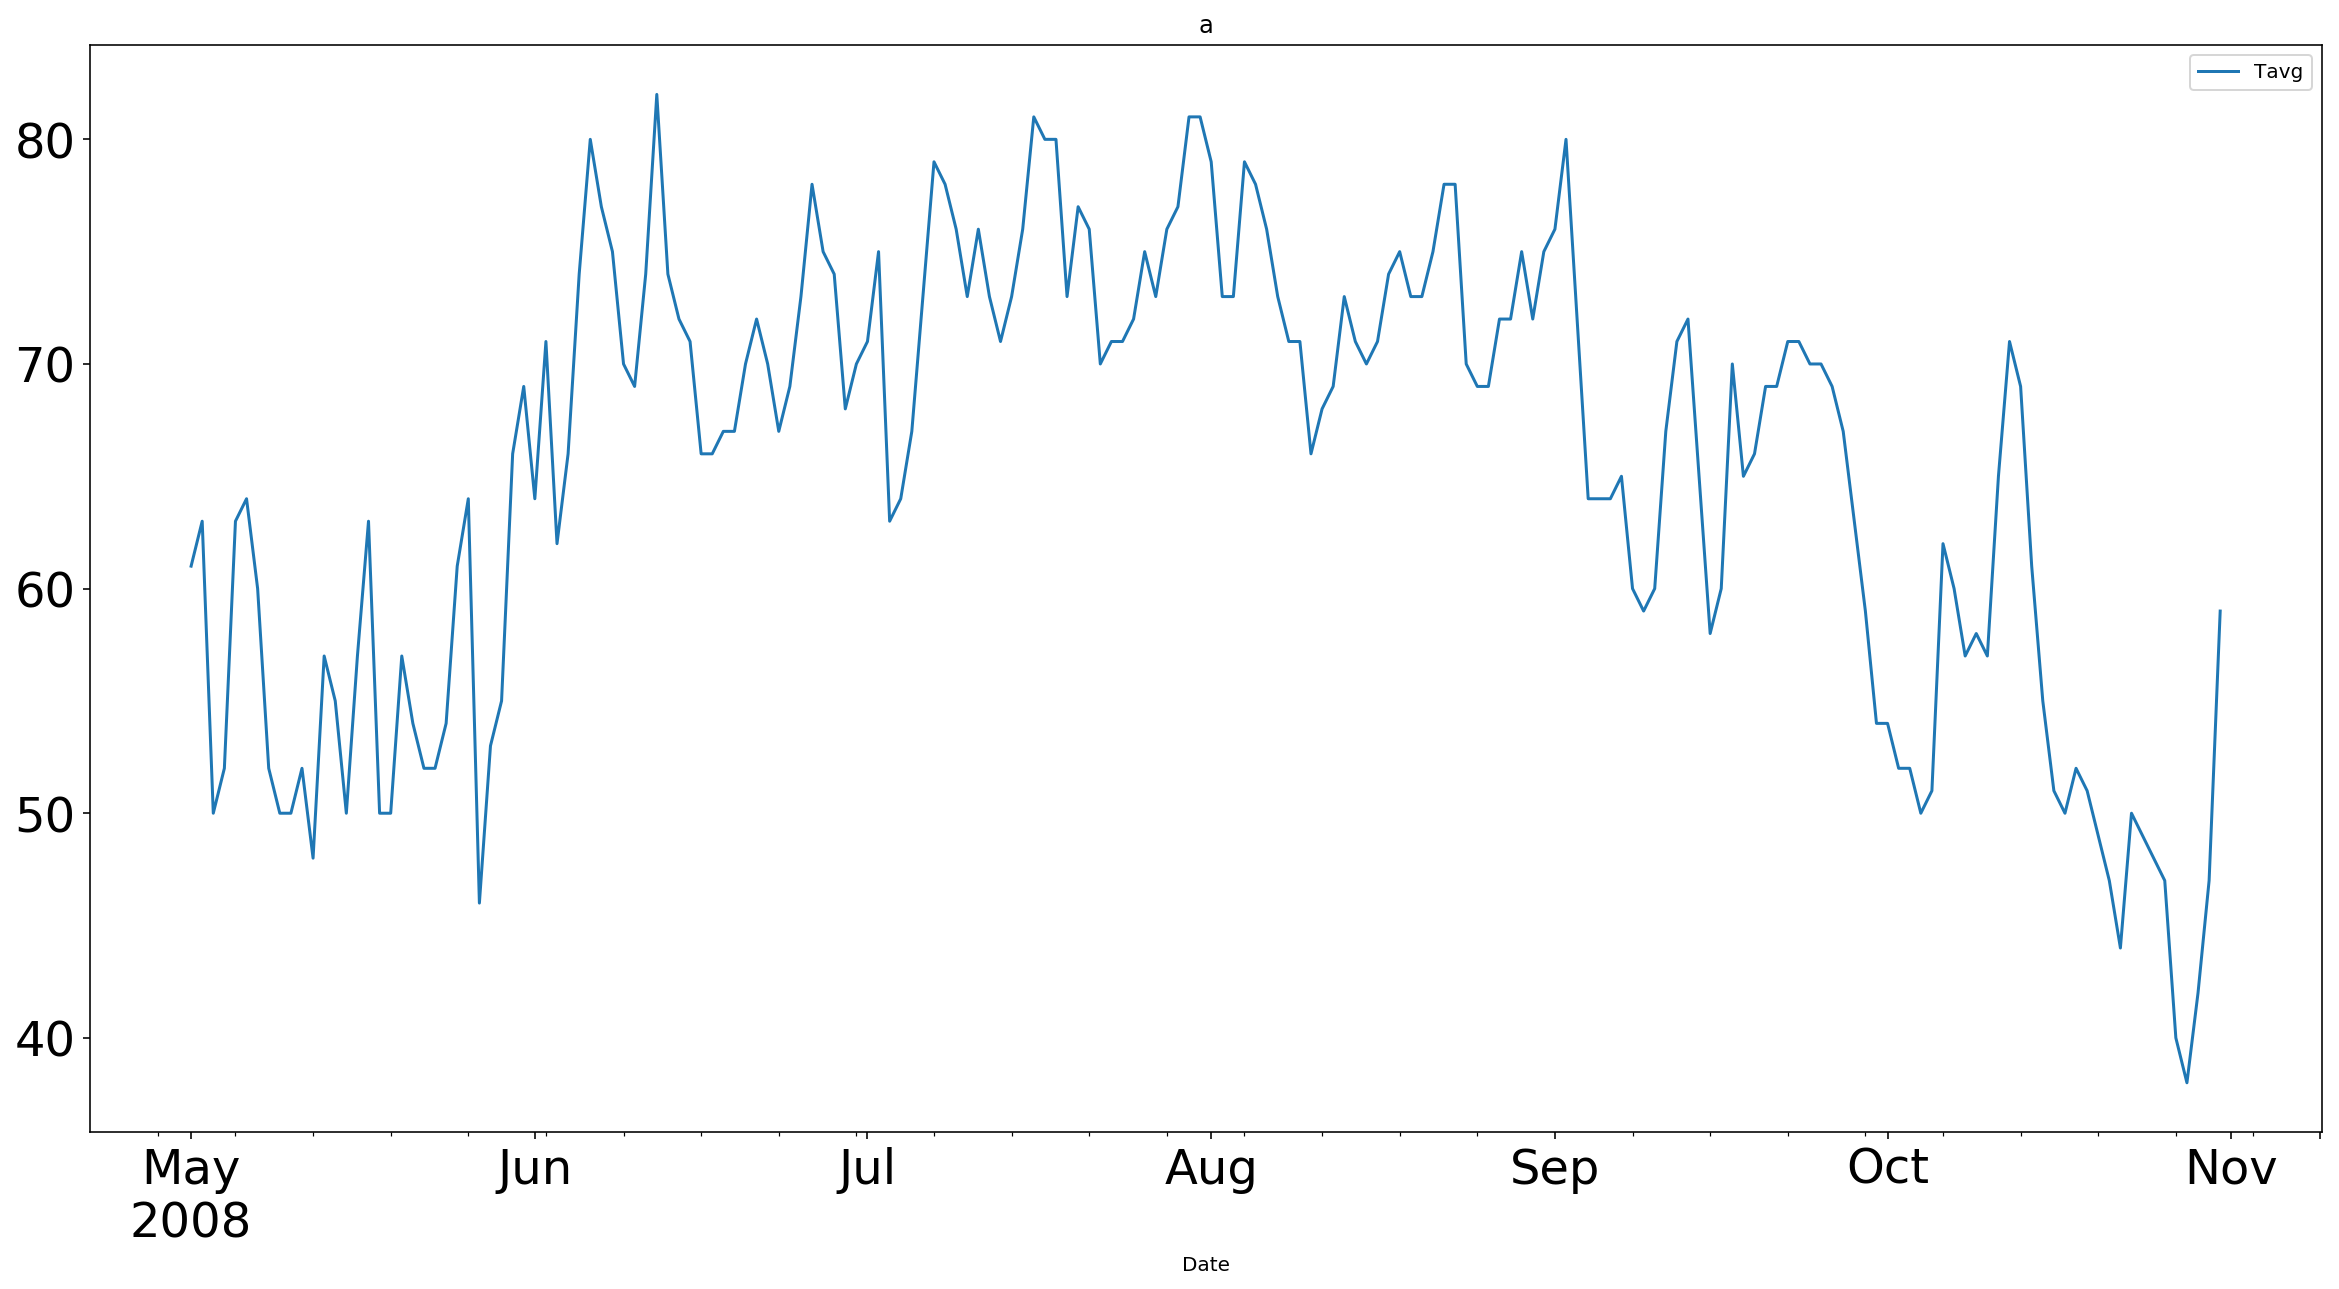

In [321]:
weather.loc[ weather['Date'].dt.year==2007, :].plot('Date','Tavg', figsize=(20,10), title='a', fontsize=24)
weather.loc[ weather['Date'].dt.year==2008, :].plot('Date','Tavg', figsize=(20,10), title='a', fontsize=24)

In [323]:
test.head()

Id       Date                 Species  Trap  Latitude  Longitude
0   1 2008-06-11  CULEX PIPIENS/RESTUANS  T002  41.95469 -87.800991
1   2 2008-06-11          CULEX RESTUANS  T002  41.95469 -87.800991
2   3 2008-06-11           CULEX PIPIENS  T002  41.95469 -87.800991
3   4 2008-06-11        CULEX SALINARIUS  T002  41.95469 -87.800991
4   5 2008-06-11         CULEX TERRITANS  T002  41.95469 -87.800991